In [1]:
import os
import numpy as np
import rasterio
from rasterio.transform import Affine
from concurrent.futures import ThreadPoolExecutor
from scipy.ndimage import rotate as nd_rotate

# ============================
# INPUT
# ============================
raster_mask_pairs = [
    ("sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif", "sarvesh/sato_new/glacier_mask_binary.tif"),
    ("sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif", "sarvesh/DATASETS_NORMALIZED/vectors/KASHMIR_CLIP.tif"),
    ("sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif", "sarvesh/DATASETS_NORMALIZED/vectors/sikkim_clip_mask.tif"),
]

output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/rasterlayer"
output_mask_dir   = "sarvesh/sato_new/sato_sikkim_kashmir/vectorlayer"
patch_size = 256

# ============================
# Directory Preparation
# ============================
def clear_and_create_dir(path):
    if os.path.exists(path):
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    else:
        os.makedirs(path)

clear_and_create_dir(output_raster_dir)
clear_and_create_dir(output_mask_dir)

# ============================
# Augmentations
# ============================
def horizontal_flip(p): return np.flip(p, axis=2)
def vertical_flip(p): return np.flip(p, axis=1)
def mirror_flip(p): return np.transpose(p, (0, 2, 1))  # diagonal flip

def rotate_90(p): return np.rot90(p, k=1, axes=(1, 2))
def rotate_180(p): return np.rot90(p, k=2, axes=(1, 2))
def rotate_270(p): return np.rot90(p, k=3, axes=(1, 2))

# Extra rotations (scipy)
def rotate_any(p, angle, order=1):
    return np.stack([
        nd_rotate(band, angle=angle, axes=(0, 1), reshape=False, order=order, mode="nearest") 
        for band in p
    ], axis=0)

def apply_augmentations(data, mask_data):
    augments = [("original", data, mask_data)]
    
    # flips & 90° rotations
    for name, func in [
        ("hflip", horizontal_flip),
        ("vflip", vertical_flip),
        ("mirror", mirror_flip),
        ("rot90", rotate_90),
        ("rot180", rotate_180),
        ("rot270", rotate_270)]:
        augments.append((name, func(data), func(mask_data)))
    
    # extra arbitrary rotations (mask nearest-neighbor safe)
    for angle in [45, 135, 225]:
        d_rot = rotate_any(data, angle, order=1)
        m_rot = rotate_any(mask_data, angle, order=0)
        augments.append((f"rot{angle}", d_rot, m_rot))
    
    return augments

# ============================
# Patch Check + Save
# ============================
def is_empty_patch(mask_patch):
    return np.all(mask_patch == 0)

def get_patch_transform(transform, i, j, patch_size):
    # Shift original transform by patch offset (j cols, i rows)
    return transform * Affine.translation(j, i)

def save_patch(data, output_dir, prefix, i, j, transform, crs, aug_name):
    filename = os.path.join(output_dir, f"{prefix}_patch_{i}_{j}_{aug_name}.tif")
    height, width = data.shape[1], data.shape[2]
    count = data.shape[0]
    patch_transform = get_patch_transform(transform, i, j, patch_size)

    with rasterio.open(
        filename, 'w', driver='GTiff',
        height=height, width=width,
        count=count, dtype=data.dtype,
        crs=crs, transform=patch_transform
    ) as dst:
        dst.write(data)

# ============================
# Main Processing
# ============================
def process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size):
    with rasterio.open(raster_path) as raster_src, rasterio.open(mask_path) as mask_src:
        raster = raster_src.read()  # (bands, h, w)
        mask = mask_src.read()      # (1, h, w) or (bands, h, w)
        crs = raster_src.crs
        transform = raster_src.transform

        # If mask is single band, enforce (1, h, w)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        h, w = raster.shape[1], raster.shape[2]
        jobs = []

        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                r_patch = raster[:, i:i+patch_size, j:j+patch_size]
                m_patch = mask[:, i:i+patch_size, j:j+patch_size]

                if r_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if m_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if is_empty_patch(m_patch):
                    continue

                for aug_name, aug_r, aug_m in apply_augmentations(r_patch, m_patch):
                    jobs.append((aug_r, output_raster_dir, 'raster', i, j, transform, crs, aug_name))
                    jobs.append((aug_m, output_mask_dir, 'mask', i, j, transform, crs, aug_name))

        # Save patches in parallel
        with ThreadPoolExecutor() as executor:
            for job in jobs:
                executor.submit(save_patch, *job)

# ============================
# Run All
# ============================
for raster_path, mask_path in raster_mask_pairs:
    print(f"Processing: {raster_path}")
    process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size)

# ============================
# Summary
# ============================
patch_count = len([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
print(f"Total {patch_size}x{patch_size} patches generated (with augmentations): {patch_count}")

Processing: sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif
Processing: sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif
Processing: sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif
Total 256x256 patches generated (with augmentations): 2230


Number of bands in raster: 18


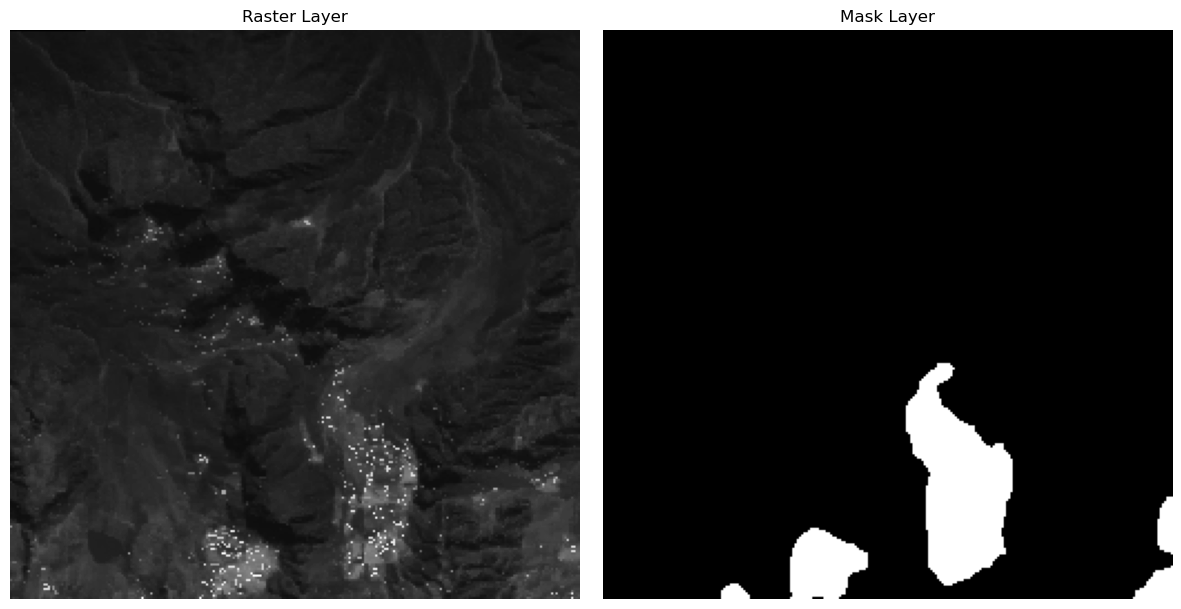

Number of bands in raster: 18


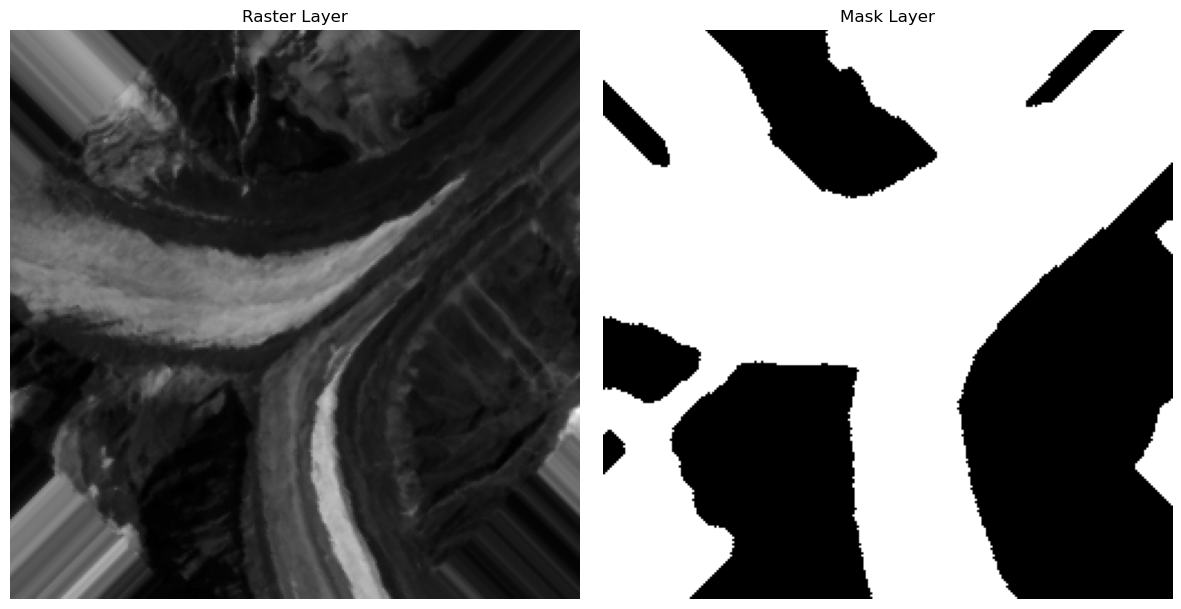

Number of bands in raster: 18


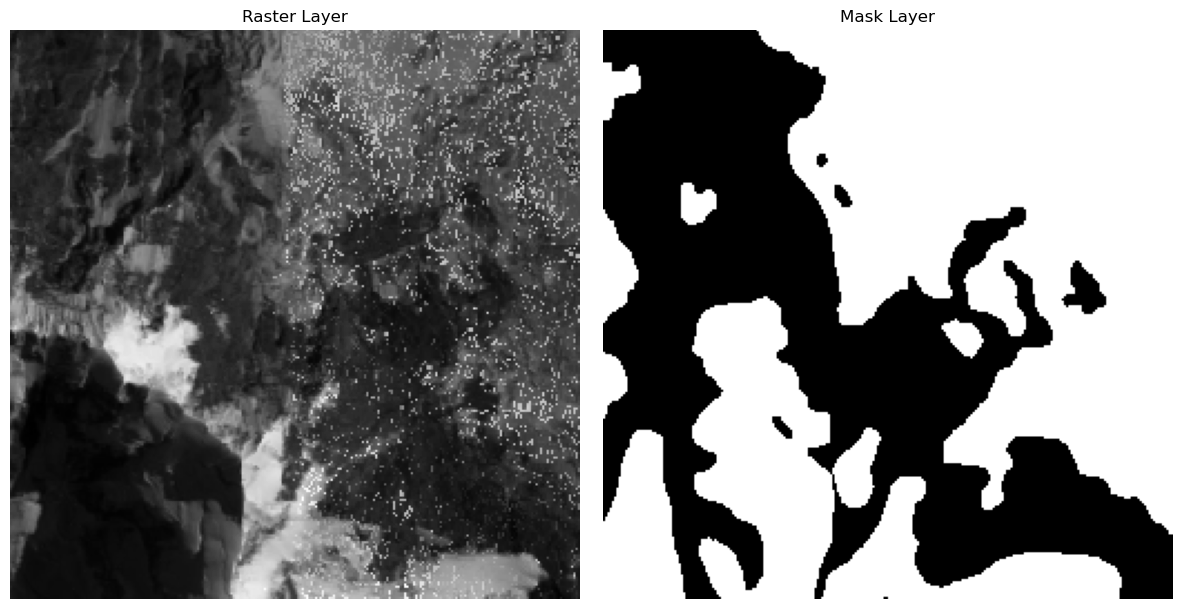

Number of bands in raster: 18


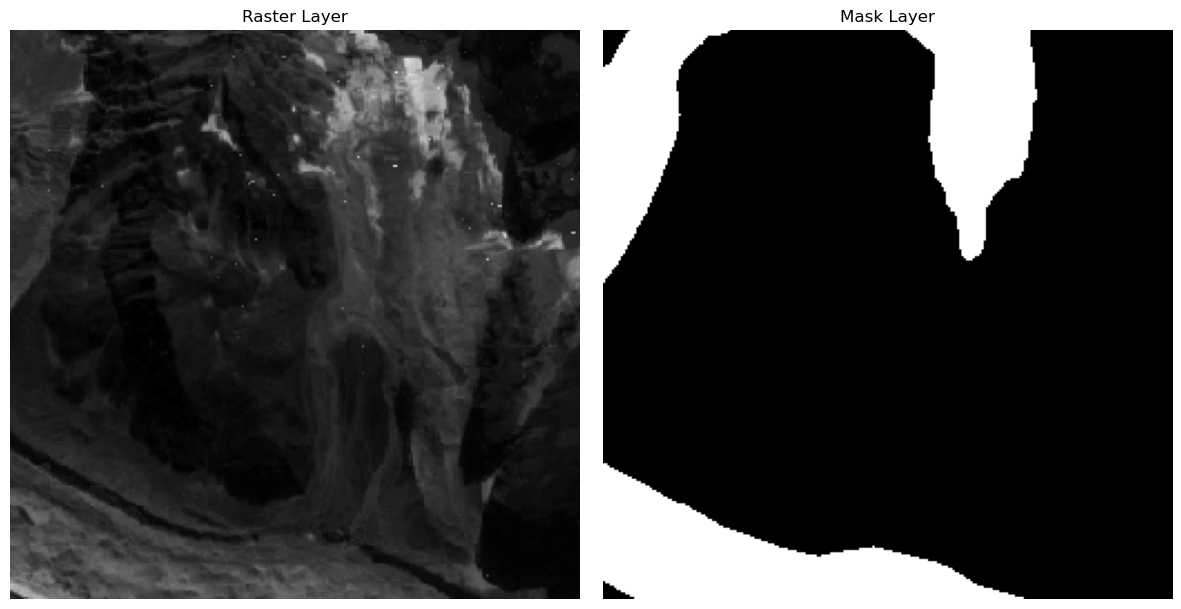

In [2]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/rasterlayer"
output_mask_dir   = "sarvesh/sato_new/sato_sikkim_kashmir/vectorlayer"
patch_size = 256

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))


In [2]:
import os
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from osgeo import gdal
import random
import tensorflow as tf
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor
import rasterio
from rasterio.windows import Window

In [3]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [7]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/rasterlayer"
output_mask_dir   = "sarvesh/sato_new/sato_sikkim_kashmir/vectorlayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 2230
Length of mask dataset: 2230
Raster height: 256
Raster width: 256
Raster channels: 18
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [4]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [9]:
import os
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Define paths
output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/rasterlayer"
output_mask_dir   = "sarvesh/sato_new/sato_sikkim_kashmir/vectorlayer"

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()  # (channels, height, width)
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    mask_files = sorted([f for f in os.listdir(directory) if f.endswith('.tif')])
    for filename in mask_files:
        file_path = os.path.join(directory, filename)
        with rasterio.open(file_path) as src:
            mask_data = src.read(1)  # (height, width) single band
            mask_list.append(mask_data)
    return np.array(mask_list)

# Load raster data
image_dataset = load_raster_dataset(output_raster_dir)
print("Original image dataset shape:", image_dataset.shape)

# Transpose image data to (n_samples, height, width, channels)
if image_dataset.ndim == 4:
    image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))  # from (N, C, H, W) to (N, H, W, C)
    print("Transposed image dataset shape:", image_dataset.shape)
else:
    print("Warning: Unexpected image dataset shape.")

# Extract dimensions
if image_dataset.size > 0:
    image_height, image_width, image_channels = image_dataset.shape[1:]
    print("Image height:", image_height)
    print("Image width:", image_width)
    print("Image channels:", image_channels)
else:
    print("Error: Empty image dataset!")

# Load mask data
mask_dataset = load_mask_dataset(output_mask_dir)
print("Mask dataset shape:", mask_dataset.shape)
print("Length of mask dataset:", len(mask_dataset))

# Unique classes in the masks
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
print("Unique labels in masks:", unique_labels)
print("Total number of unique classes:", total_classes)

# One-hot encode the masks
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
if image_dataset.shape[0] == labels_categorical_dataset.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(
        image_dataset,
        labels_categorical_dataset,
        test_size=0.01,
        random_state=100
    )

    print("Dataset split completed.")
    print("Training set shape (X, y):", X_train.shape, y_train.shape)
    print("Testing set shape (X, y):", X_test.shape, y_test.shape)
else:
    print("Mismatch in number of images and masks!")

Original image dataset shape: (2230, 18, 256, 256)
Transposed image dataset shape: (2230, 256, 256, 18)
Image height: 256
Image width: 256
Image channels: 18
Mask dataset shape: (2230, 256, 256)
Length of mask dataset: 2230
Unique labels in masks: [0. 1.]
Total number of unique classes: 2
Dataset split completed.
Training set shape (X, y): (2207, 256, 256, 18) (2207, 256, 256, 2)
Testing set shape (X, y): (23, 256, 256, 18) (23, 256, 256, 2)


In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2207, 256, 256, 18)
(23, 256, 256, 18)
(2207, 256, 256, 2)
(23, 256, 256, 2)


In [5]:
from keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [6]:
import os
import numpy as np
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Add, Activation, Multiply, GlobalAveragePooling2D, DepthwiseConv2D, Reshape, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2

In [14]:
output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/rasterlayer"
output_mask_dir   = "sarvesh/sato_new/sato_sikkim_kashmir/vectorlayer"
patch_size = 256  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [15]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.05, random_state=100
)

In [25]:
import tensorflow as tf

def jaccard_coef(y_true, y_pred):
    # Ensure both y_true and y_pred are float32 using tf.cast
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten the inputs
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [26]:
model = unet_plus_plus(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), n_classes=total_classes)
dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
#dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(optimizer=Adam(), loss=total_loss, metrics=["accuracy", jaccard_coef])

In [27]:
# Define U-Net Plus Plus model
def jaccard_coef(y_true, y_pred):
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

def conv_block(inputs, filters, dropout=0.2):
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x

def unet_plus_plus(n_classes=1, input_shape=(64, 64, 1)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Nested and dense skip connections
    u4_1 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4_1 = tf.keras.layers.concatenate([u4_1, c4])
    c4_1 = conv_block(u4_1, 512)

    u3_2 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4_1)
    u3_2 = tf.keras.layers.concatenate([u3_2, c3])
    c3_2 = conv_block(u3_2, 256)

    u2_3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3_2)
    u2_3 = tf.keras.layers.concatenate([u2_3, c2])
    c2_3 = conv_block(u2_3, 128)

    u1_4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c2_3)
    u1_4 = tf.keras.layers.concatenate([u1_4, c1])
    c1_4 = conv_block(u1_4, 64)

    # Output layer
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c1_4)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 18)]       0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         10432     ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 64)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['dropout_18[0][0]']          
                                                                                            

In [28]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster GPU computation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Path to save the model
model_save_path = 'sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5'

#Increased Learning Rate for Faster Training
learning_rate = 1e-3  

#Use Adam Optimizer with New Learning Rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A4000, compute capability 8.6


In [29]:
# Model checkpoint callback (save the best model)
model_checkpoint = ModelCheckpoint(
    model_save_path, 
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose=1            
)

# Increase batch size to fully utilize GPU
batch_size = 16

# Train the model with mixed precision and improved performance
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000


2025-08-19 15:13:21.677374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-19 15:13:22.435823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-08-19 15:13:22.557240: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-19 15:13:22.936403: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-19 15:13:25.967777: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x78c2f494fca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 15:13:25.967820: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capabili

133/133 [==============================] - ETA: 0s - loss: 5.4922 - accuracy: 0.7922
Epoch 1: val_loss improved from inf to 0.35275, saving model to sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5


/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 83s 458ms/step - loss: 5.4922 - accuracy: 0.7922 - val_loss: 0.3527 - val_accuracy: 0.7662
Epoch 2/1000
133/133 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8584
Epoch 2: val_loss improved from 0.35275 to 0.29102, saving model to sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5
133/133 [==============================] - 55s 418ms/step - loss: 0.2932 - accuracy: 0.8584 - val_loss: 0.2910 - val_accuracy: 0.8646
Epoch 3/1000
133/133 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.8939
Epoch 3: val_loss improved from 0.29102 to 0.27591, saving model to sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5
133/133 [==============================] - 59s 442ms/step - loss: 0.2576 - accuracy: 0.8939 - val_loss: 0.2759 - val_accuracy: 0.8966
Epoch 4/1000
133/133 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9020
Epoch 4: val_loss improved from 0.27591 to

In [30]:
tf.keras.backend.clear_session()

In [31]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (2118, 256, 256, 18)
y_train shape: (2118, 256, 256, 2)
Model output shape: (None, 256, 256, 2)


In [32]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 256, 256, 2)
Training labels shape: (2118, 256, 256, 2)


Text(0.5, 1.0, 'Model Accuracy')

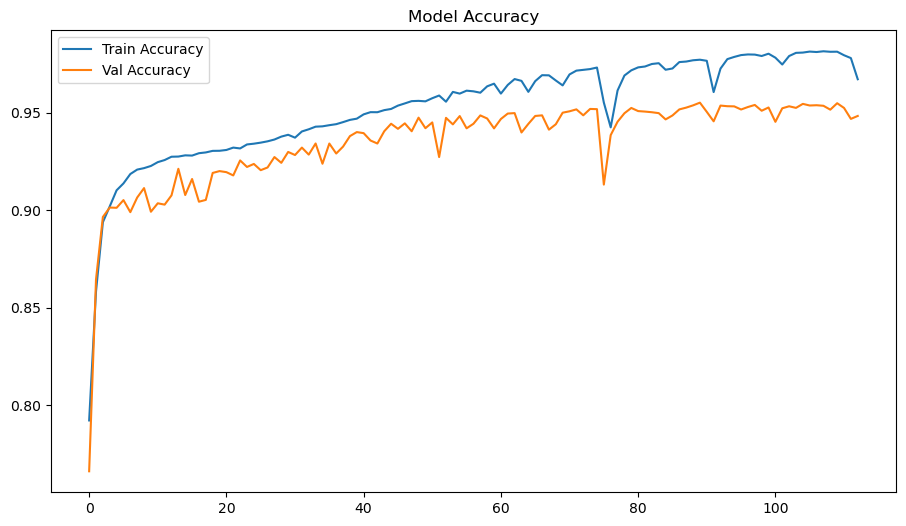

In [33]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

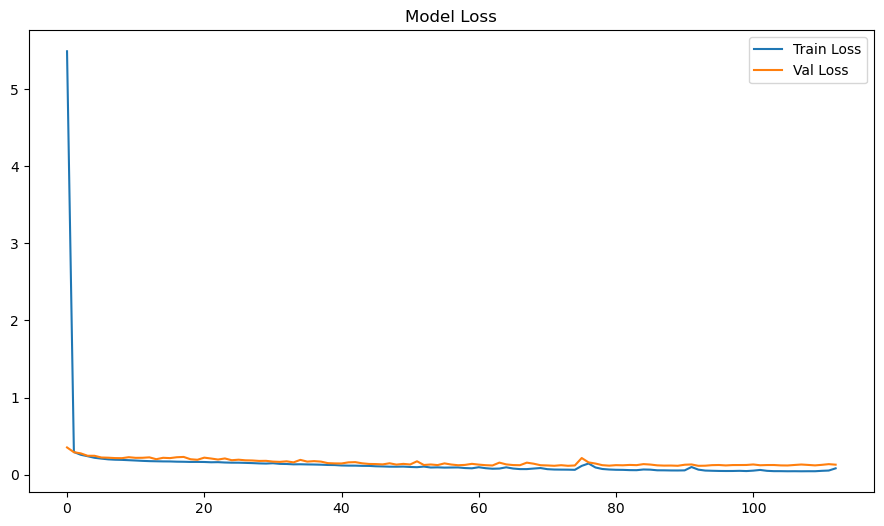

In [39]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [34]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

4/4 [==============================] - 6s 133ms/step


In [35]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [36]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

1/1 [==============================] - 0s 48ms/step


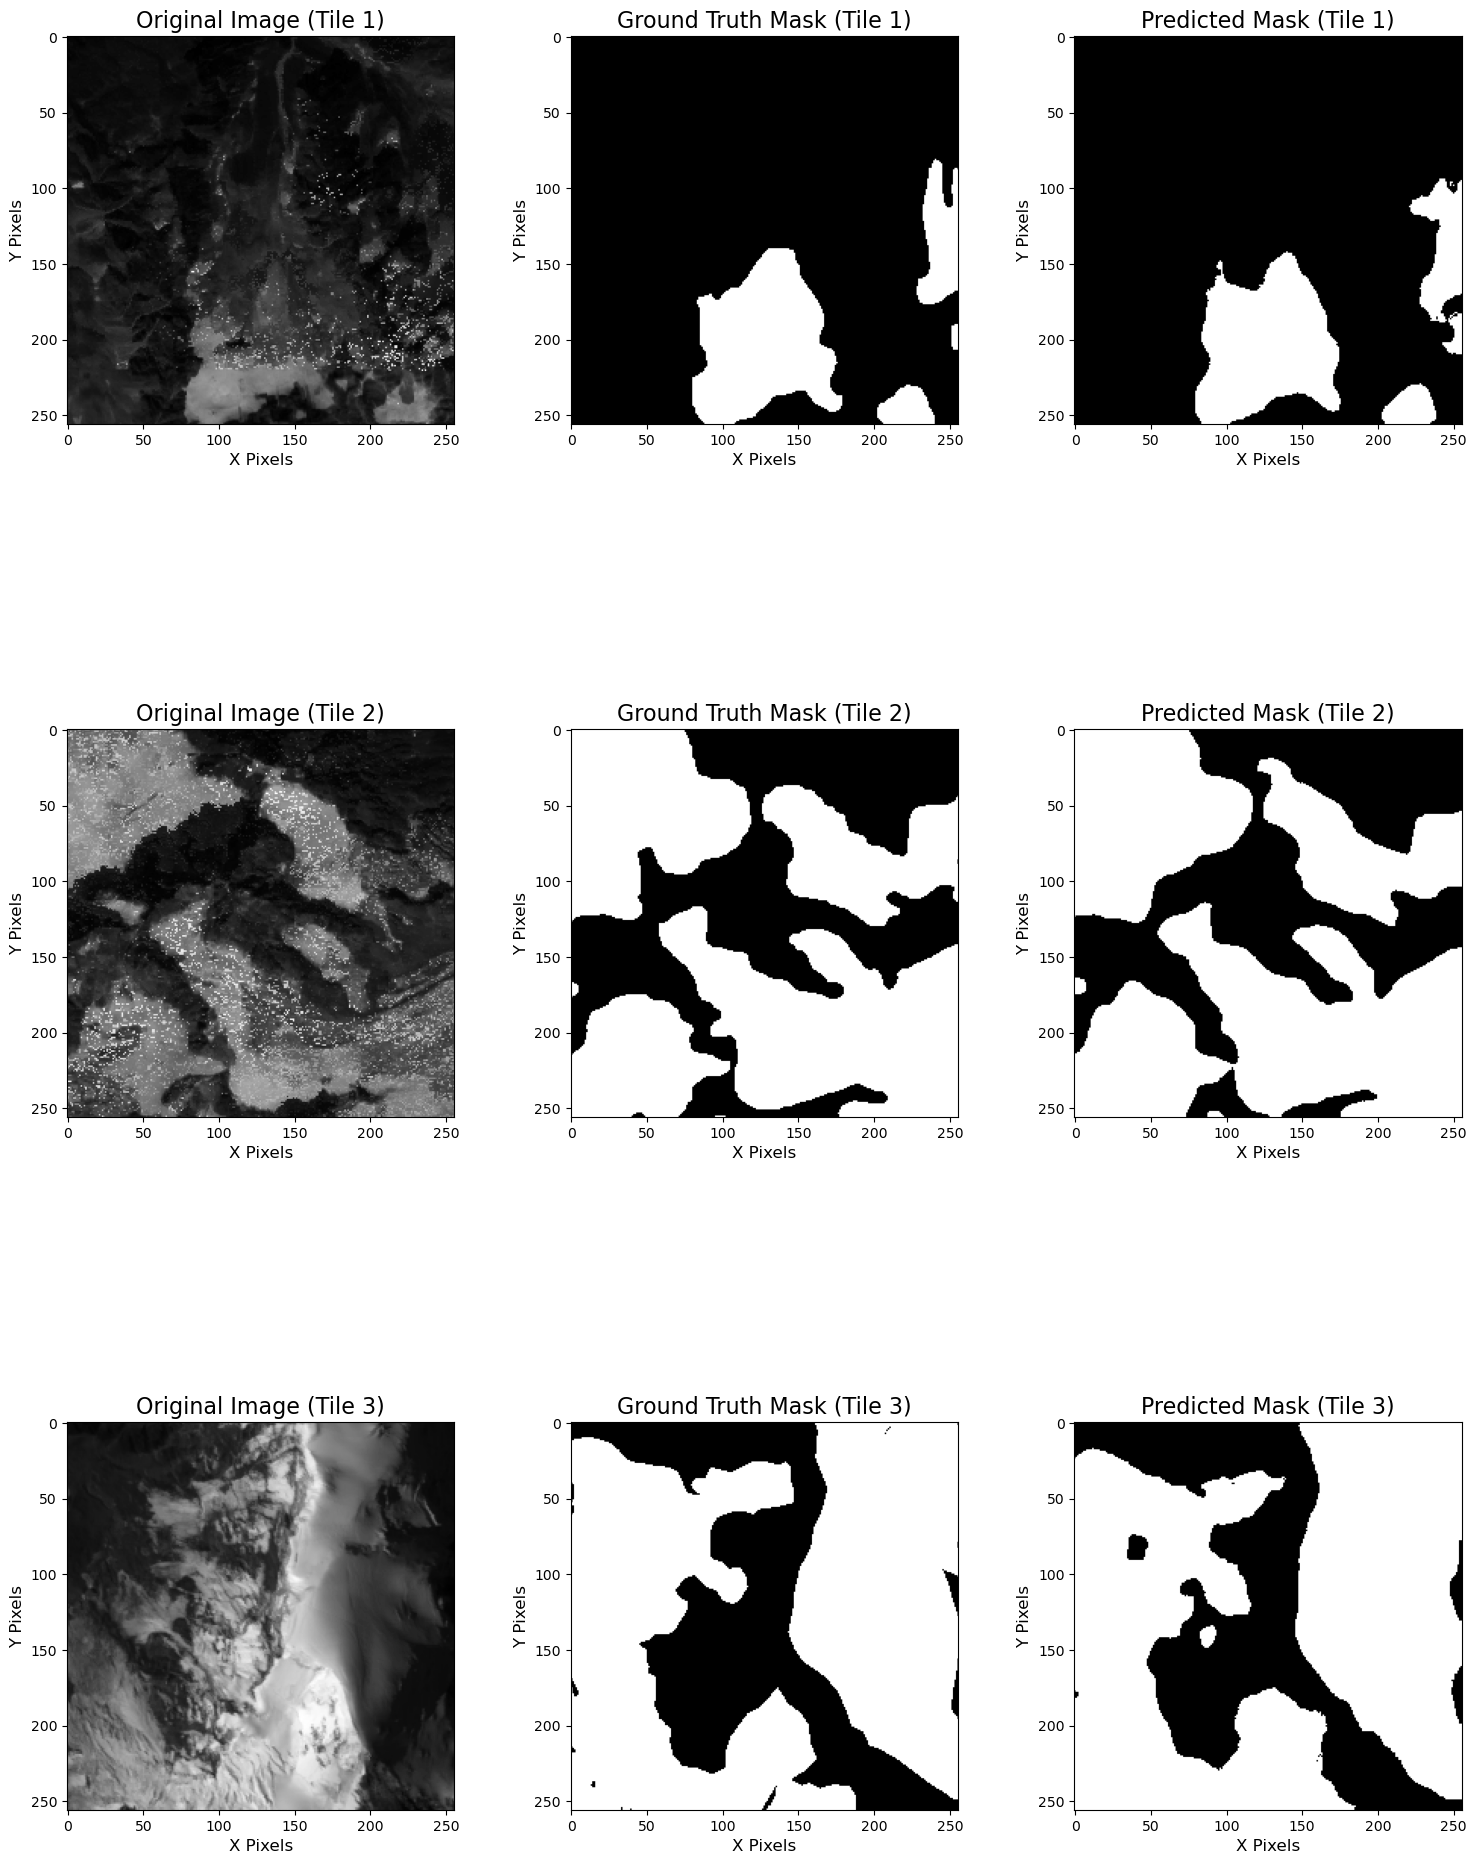

In [37]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [38]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model_path = 'sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5'
# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 18)]       0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 64)         10432     ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 64)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 64)         36928     ['dropout_18[0][0]']          
                                                                                            

In [40]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import os

# Define paths
model_path = 'sarvesh/sato_new/sato_sikkim_kashmir/uk_sik_kash_unet_model.h5'
raster_files = [
    'sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif',
    'sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif',
    'sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif',
    'sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif',
    'sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif'
    
]
output_dir = 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18'

# Load the model
model = load_model(model_path, compile=False)

# Patch and overlap settings
patch_size = 256
overlap = 128
stride = patch_size - overlap

# Blending matrix
blend_matrix = np.ones((patch_size, patch_size))
for i in range(overlap):
    weight = (i + 1) / overlap
    blend_matrix[i, :] *= weight
    blend_matrix[-(i + 1), :] *= weight
    blend_matrix[:, i] *= weight
    blend_matrix[:, -(i + 1)] *= weight

# Process each raster file
for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    # Transpose raster to (H, W, C)
    raster_data = np.transpose(raster_data, (1, 2, 0))
    height, width, channels = raster_data.shape

    # Pad raster
    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Predict full raster via sliding window
    predicted_raster = np.zeros((raster_data_padded.shape[0], raster_data_padded.shape[1]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[0] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
            patch = raster_data_padded[i:i + patch_size, j:j + patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()

            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    # Normalize and crop
    weight_sum[weight_sum == 0] = 1
    predicted_raster = (predicted_raster / weight_sum).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    # Save predicted raster
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    predicted_raster_path = os.path.join(output_dir, f'{base_name}_sato_unet18.tif')

    raster_profile.update({
        'count': 1,
        'dtype': 'uint8',
        'compress': 'lzw',
        'nodata': 0
    })

    with rasterio.open(predicted_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Predicted raster saved: {predicted_raster_path}")

    # Convert raster to shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_sato_unet18_mask.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Shapefile saved: {shapefile_path}")

Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/raster_cb__normalized_sato_unet18.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/raster_cb__normalized_sato_unet18_mask.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/cb_vali_normalized_128_sato_unet18.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/cb_vali_normalized_128_sato_unet18_mask.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/NEW_UK_TIF_fixedB10_sato_unet18.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/NEW_UK_TIF_fixedB10_sato_unet18_mask.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/sikkim_chaudhary_255_final_sato_unet18.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/sikkim_chaudhary_255_final_sato_unet18_mask.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/sf_18/KASHMIR_NORMALIZED_255_final_sato_unet18.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_ka

Input image shape: (1, 256, 256, 18)
Predictions shape: (1, 256, 256, 2)
Class index: 1


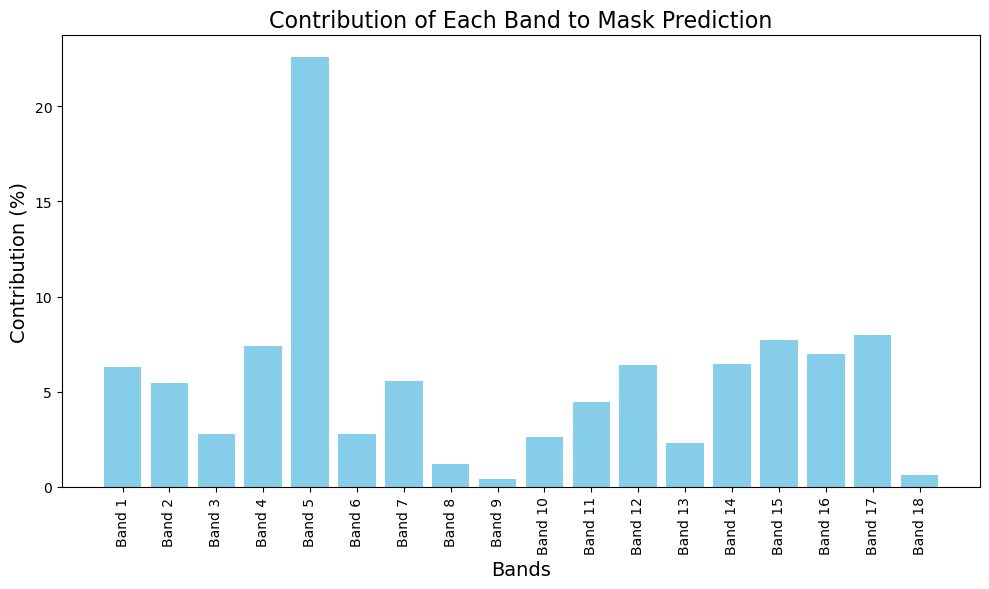

Band 1: 6.29% contribution
Band 2: 5.45% contribution
Band 3: 2.76% contribution
Band 4: 7.40% contribution
Band 5: 22.61% contribution
Band 6: 2.76% contribution
Band 7: 5.57% contribution
Band 8: 1.18% contribution
Band 9: 0.42% contribution
Band 10: 2.63% contribution
Band 11: 4.48% contribution
Band 12: 6.38% contribution
Band 13: 2.31% contribution
Band 14: 6.46% contribution
Band 15: 7.72% contribution
Band 16: 6.98% contribution
Band 17: 7.99% contribution
Band 18: 0.63% contribution


In [42]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Select a random test image
test_image_number = random.randint(0, len(X_test) - 1)
test_image = X_test[test_image_number]

# Ensure the input image has the correct shape
input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)
print(f"Input image shape: {input_image.shape}")  # Should print (1, 64, 64, 18)

# Get model predictions
predictions = model(input_image)
print(f"Predictions shape: {predictions.shape}")  # Should print (1, 64, 64, num_classes)

# Choose the class index (0 or 1) to analyze the gradients for
class_index = 1  # For example, class 1 (you can change to 0 to analyze the other class)
print(f"Class index: {class_index}")

# Initialize a GradientTape to compute gradients
with tf.GradientTape() as tape:
    tape.watch(input_image)  # Watch the input image for gradients
    predictions = model(input_image)
    class_predictions = predictions[0, :, :, class_index]  # Select the predicted class map

# Compute the gradients of the predicted class with respect to each input band (channel)
grads = tape.gradient(class_predictions, input_image)

# Calculate the mean gradient for each band (across height and width)
mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

# Normalize the gradients to calculate contributions as percentages
total_grad = np.sum(np.abs(mean_grads))
contributions = (np.abs(mean_grads) / total_grad) * 100  # Percentage contribution of each band

# Plot the contributions of each band
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(18)]
plt.bar(bands, contributions, color='skyblue')
plt.title('Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")

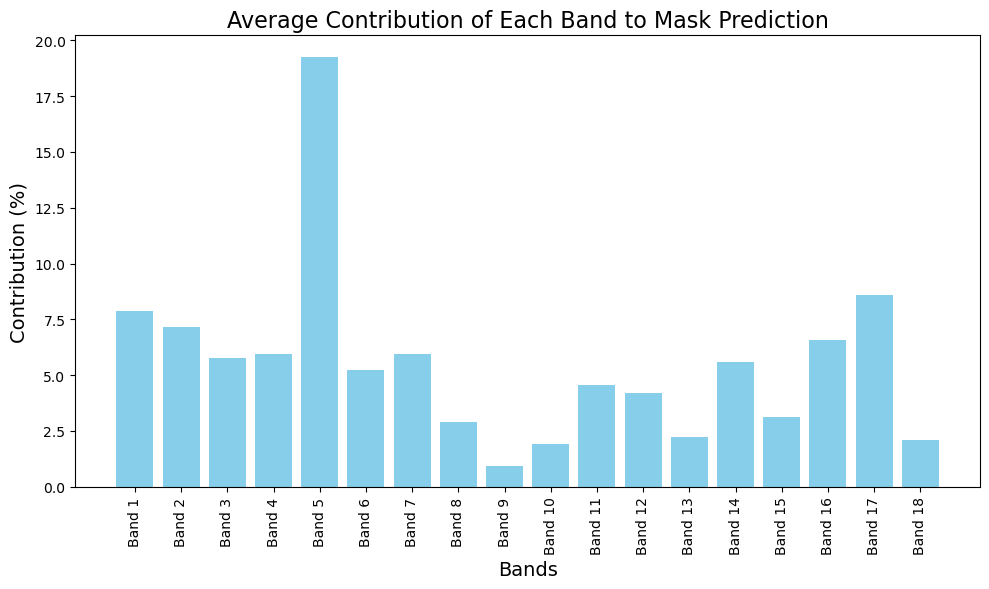

Band 1: 7.89% contribution
Band 2: 7.18% contribution
Band 3: 5.76% contribution
Band 4: 5.96% contribution
Band 5: 19.26% contribution
Band 6: 5.22% contribution
Band 7: 5.97% contribution
Band 8: 2.92% contribution
Band 9: 0.95% contribution
Band 10: 1.92% contribution
Band 11: 4.57% contribution
Band 12: 4.21% contribution
Band 13: 2.23% contribution
Band 14: 5.58% contribution
Band 15: 3.15% contribution
Band 16: 6.56% contribution
Band 17: 8.58% contribution
Band 18: 2.09% contribution


In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

all_contributions = []

for test_image in X_test:
    input_image = tf.convert_to_tensor(np.expand_dims(test_image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        class_predictions = predictions[0, :, :, class_index]  

    grads = tape.gradient(class_predictions, input_image)
    mean_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    
    total_grad = np.sum(np.abs(mean_grads))

    if total_grad == 0:
        contributions = np.zeros_like(mean_grads)  # Handle zero division safely
    else:
        contributions = (np.abs(mean_grads) / total_grad) * 100  

    all_contributions.append(contributions)

# Compute average contribution across all patches
avg_contributions = np.mean(all_contributions, axis=0)

# Plot
plt.figure(figsize=(10, 6))
bands = [f'Band {i+1}' for i in range(len(avg_contributions))]
plt.bar(bands, avg_contributions, color='skyblue')
plt.title('Average Contribution of Each Band to Mask Prediction', fontsize=16)
plt.xlabel('Bands', fontsize=14)
plt.ylabel('Contribution (%)', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the percentage contribution of each band
for i, contribution in enumerate(avg_contributions):
    print(f"Band {i+1}: {contribution:.2f}% contribution")


=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[84307385 11048840]
 [ 2325762  9668843]]
Overall Accuracy: 0.8754
Mean IoU: 0.6413
F1 Score: 0.7588
Recall: 0.8451
Precision: 0.7199
Cohen's Kappa: 0.5237

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20222062   173476]
 [  715378  1820748]]
Overall Accuracy: 0.9612
Mean IoU: 0.8149
F1 Score: 0.8911
Recall: 0.8547
Precision: 0.9394
Cohen's Kappa: 0.7826

=== Processing uk ===
Confusion Matrix:
[[13539010   174702]
 [  446876  4580147]]
Overall Accuracy: 0.9668
Mean IoU: 0.9183
F1 Score: 0.9570
Recall: 0.9492
Precision: 0.9657
Cohen's Kappa: 0.9140

=== Processing KASHMIR ===
Confusion Matrix:
[[23202117    61460]
 [   79476   536907]]
Overall Accuracy: 0.9941
Mean IoU: 0.8930
F1 Score: 0.9405
Recall: 0.9342
Precision: 0.9469
Cohen's Kappa: 0.8810

=== Processing SIKKIM ===
Confusion Matrix:
[[18637394   142657]
 [   72634   431327]]
Overall Accuracy: 0.9888
Mean IoU: 0.8278
F1 Score: 0.8973
Recall: 0.9241
Precision: 0.

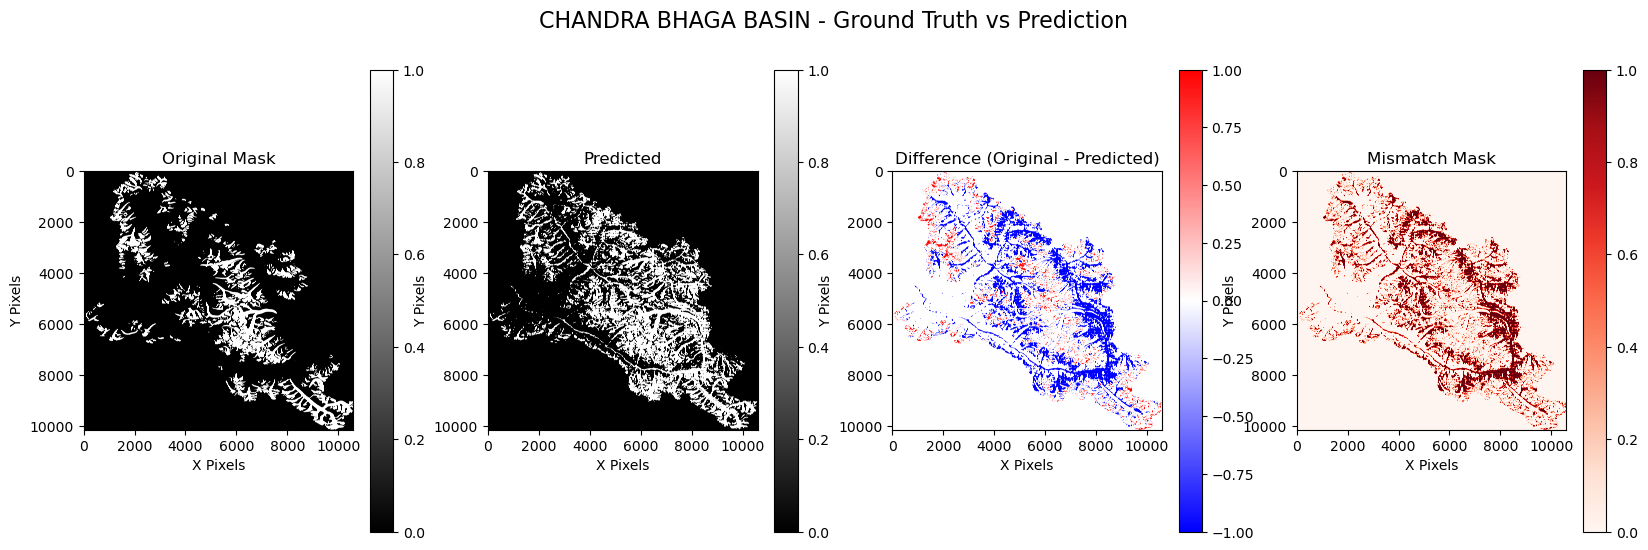

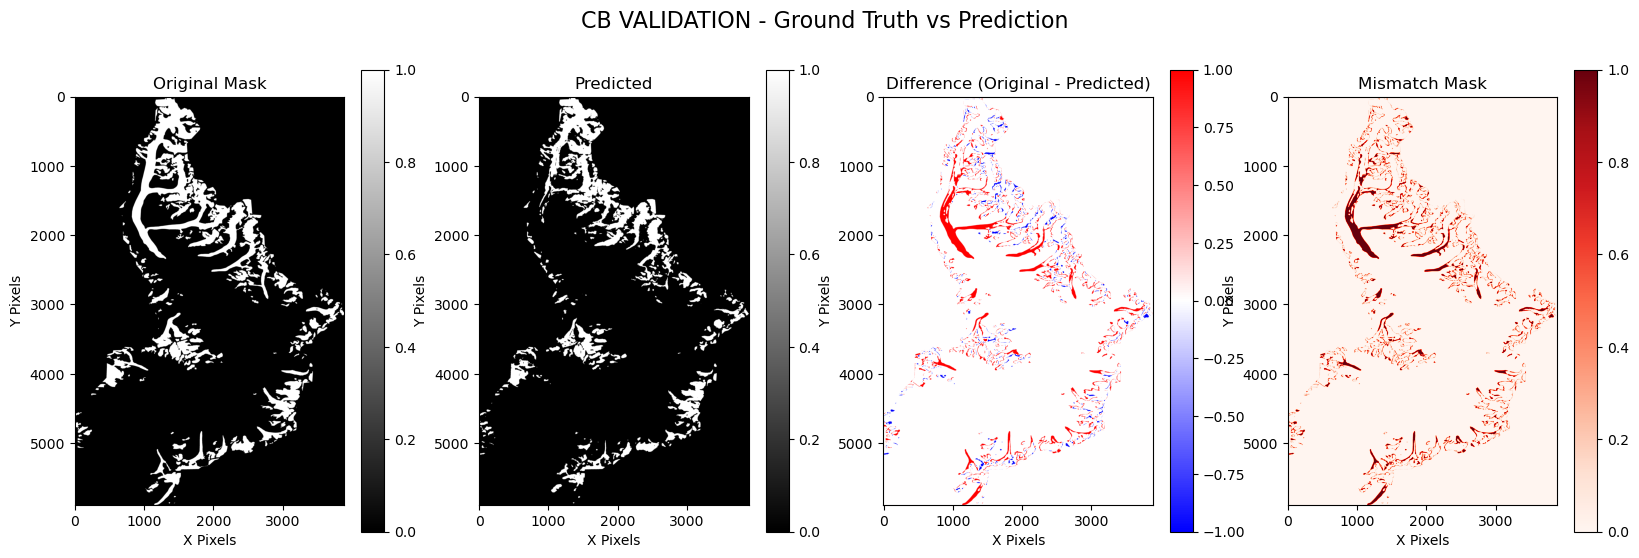

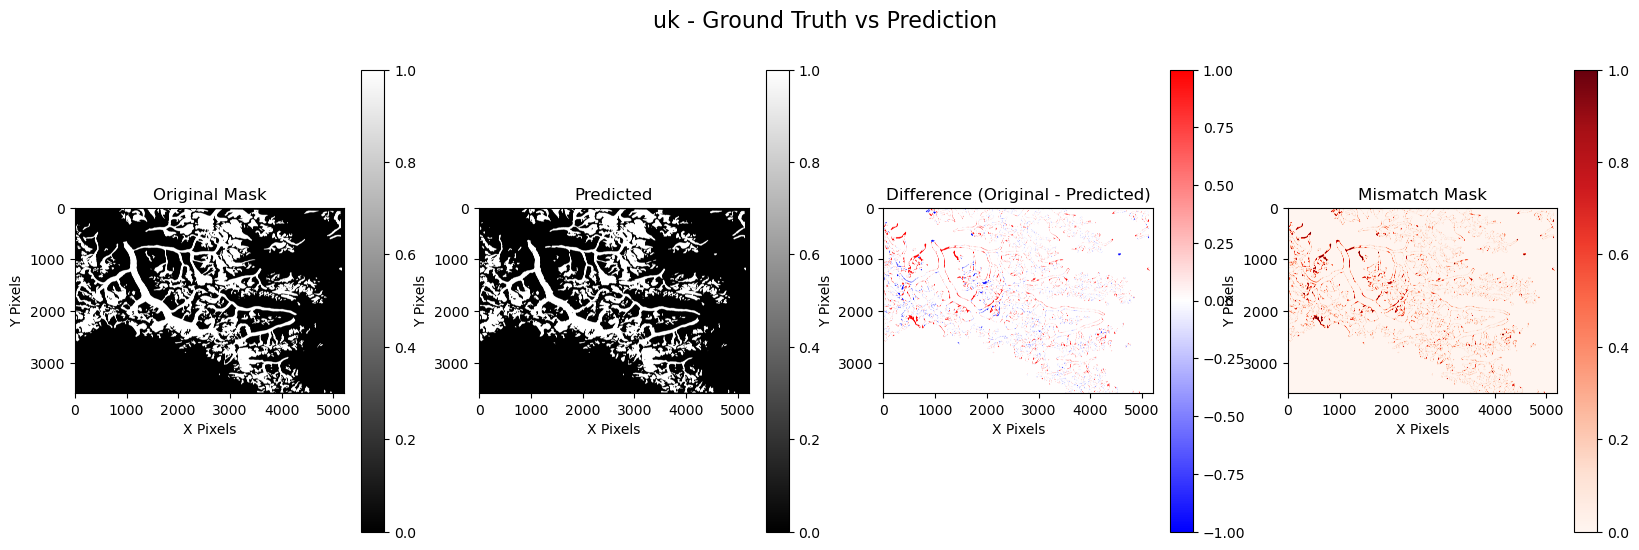

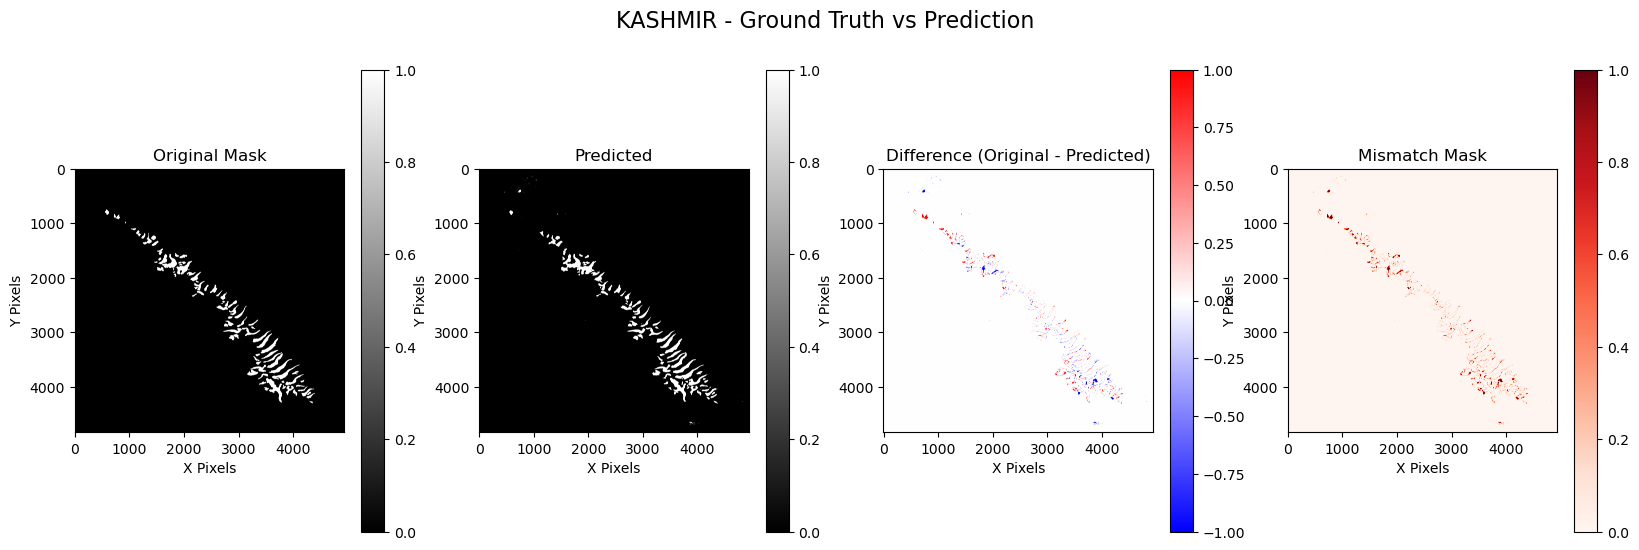

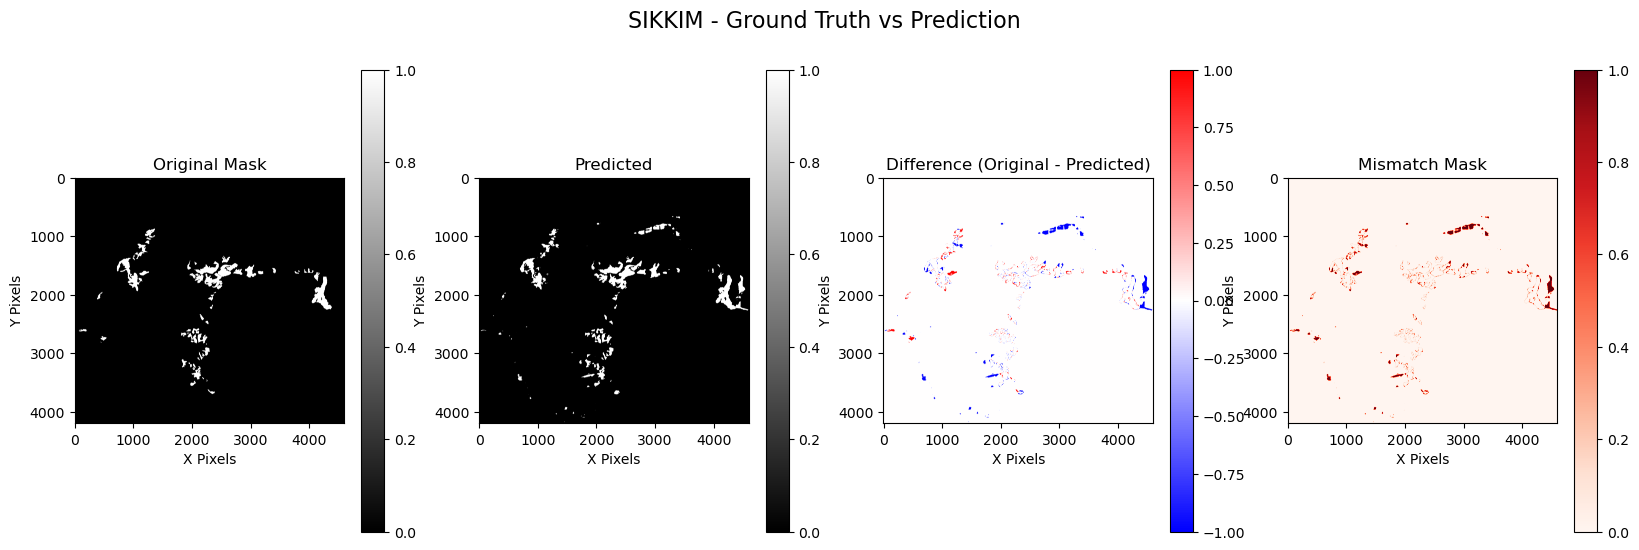

In [44]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18/raster_cb__normalized_sato_unet18.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18/cb_vali_normalized_128_sato_unet18.tif',
        'label': 'CB VALIDATION'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18/NEW_UK_TIF_fixedB10_sato_unet18.tif',
        'label': 'uk'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18/KASHMIR_NORMALIZED_255_final_sato_unet18.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/sf_18/sikkim_chaudhary_255_final_sato_unet18.tif',
        'label': 'SIKKIM'
    },
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()

In [45]:
import rasterio
import numpy as np
import os

# Input raster file paths
raster_files = [
    "sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif",
    "sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif"
]

# Output directory for filtered rasters
output_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6"
os.makedirs(output_dir, exist_ok=True)

# Top 6 contributing bands (1-based indices)
top_6_bands = [5, 17, 1, 2, 16, 7]

# Process each raster file
for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        num_bands = src.count
        selected_bands = [b for b in top_6_bands if b <= num_bands]

        # Read and stack the selected bands
        selected_data = np.stack([src.read(b) for b in selected_bands])

        # Output file name
        output_filename = os.path.join(
            output_dir,
            os.path.basename(raster_path).replace(".tif", "_6band_all.tif")
        )

        # Write filtered raster
        with rasterio.open(
            output_filename, 'w', driver='GTiff',
            height=src.height, width=src.width,
            count=len(selected_bands), dtype=src.dtypes[0],
            crs=src.crs, transform=src.transform
        ) as dst:
            dst.write(selected_data)

        print(f"Processed: {raster_path} → Saved: {output_filename}")

print("Top 6 band filtering complete!")

Processed: sarvesh/sato_new/NEW_UK_TIF_fixedB10.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/NEW_UK_TIF_fixedB10_6band_all.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/KASMIR_255_CLIP.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/KASMIR_255_CLIP_6band_all.tif
Processed: sarvesh/DATASETS_NORMALIZED/rasters/sikkim_255_clip.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sikkim_255_clip_6band_all.tif
Top 6 band filtering complete!


In [46]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from concurrent.futures import ThreadPoolExecutor

# ============================
# INPUT
# ============================
raster_mask_pairs = [
    ("sarvesh/sato_new/sato_sikkim_kashmir/top6/NEW_UK_TIF_fixedB10_6band_all.tif", "sarvesh/sato_new/glacier_mask_binary.tif"),
    ("sarvesh/sato_new/sato_sikkim_kashmir/top6/KASMIR_255_CLIP_6band_all.tif", "sarvesh/DATASETS_NORMALIZED/vectors/KASHMIR_CLIP.tif"),
    ("sarvesh/sato_new/sato_sikkim_kashmir/top6/sikkim_255_clip_6band_all.tif", "sarvesh/DATASETS_NORMALIZED/vectors/sikkim_clip_mask.tif")
]

output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/rasterlayer"
output_mask_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/masklayer"
patch_size = 256

# ============================
# Directory Preparation
# ============================
def clear_and_create_dir(path):
    if os.path.exists(path):
        for f in os.listdir(path):
            os.remove(os.path.join(path, f))
    else:
        os.makedirs(path)

clear_and_create_dir(output_raster_dir)
clear_and_create_dir(output_mask_dir)

# ============================
# Augmentations
# ============================
def horizontal_flip(p): return np.flip(p, axis=2)
def vertical_flip(p): return np.flip(p, axis=1)
def mirror_flip(p): return np.transpose(p, (0, 2, 1))  # diagonal flip

def rotate_90(p): return np.rot90(p, k=1, axes=(1, 2))
def rotate_180(p): return np.rot90(p, k=2, axes=(1, 2))
def rotate_270(p): return np.rot90(p, k=3, axes=(1, 2))

# Extra rotations (scipy)
def rotate_any(p, angle, order=1):
    return np.stack([
        nd_rotate(band, angle=angle, axes=(0, 1), reshape=False, order=order, mode="nearest") 
        for band in p
    ], axis=0)

def apply_augmentations(data, mask_data):
    augments = [("original", data, mask_data)]
    
    # flips & 90° rotations
    for name, func in [
        ("hflip", horizontal_flip),
        ("vflip", vertical_flip),
        ("mirror", mirror_flip),
        ("rot90", rotate_90),
        ("rot180", rotate_180),
        ("rot270", rotate_270)]:
        augments.append((name, func(data), func(mask_data)))
    
    # extra arbitrary rotations (mask nearest-neighbor safe)
    for angle in [45, 135, 225]:
        d_rot = rotate_any(data, angle, order=1)
        m_rot = rotate_any(mask_data, angle, order=0)
        augments.append((f"rot{angle}", d_rot, m_rot))
    
    return augments

# ============================
# Patch Check + Save
# ============================
def is_empty_patch(mask_patch):
    return np.all(mask_patch == 0)

def get_patch_transform(transform, i, j, patch_size):
    # Shift original transform by patch offset (j cols, i rows)
    return transform * Affine.translation(j, i)

def save_patch(data, output_dir, prefix, i, j, transform, crs, aug_name):
    filename = os.path.join(output_dir, f"{prefix}_patch_{i}_{j}_{aug_name}.tif")
    height, width = data.shape[1], data.shape[2]
    count = data.shape[0]
    patch_transform = get_patch_transform(transform, i, j, patch_size)

    with rasterio.open(
        filename, 'w', driver='GTiff',
        height=height, width=width,
        count=count, dtype=data.dtype,
        crs=crs, transform=patch_transform
    ) as dst:
        dst.write(data)

# ============================
# Main Processing
# ============================
def process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size):
    with rasterio.open(raster_path) as raster_src, rasterio.open(mask_path) as mask_src:
        raster = raster_src.read()  # (bands, h, w)
        mask = mask_src.read()      # (1, h, w) or (bands, h, w)
        crs = raster_src.crs
        transform = raster_src.transform

        # If mask is single band, enforce (1, h, w)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=0)

        h, w = raster.shape[1], raster.shape[2]
        jobs = []

        for i in range(0, h - patch_size + 1, patch_size):
            for j in range(0, w - patch_size + 1, patch_size):
                r_patch = raster[:, i:i+patch_size, j:j+patch_size]
                m_patch = mask[:, i:i+patch_size, j:j+patch_size]

                if r_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if m_patch.shape[1:] != (patch_size, patch_size):
                    continue
                if is_empty_patch(m_patch):
                    continue

                for aug_name, aug_r, aug_m in apply_augmentations(r_patch, m_patch):
                    jobs.append((aug_r, output_raster_dir, 'raster', i, j, transform, crs, aug_name))
                    jobs.append((aug_m, output_mask_dir, 'mask', i, j, transform, crs, aug_name))

        # Save patches in parallel
        with ThreadPoolExecutor() as executor:
            for job in jobs:
                executor.submit(save_patch, *job)

# ============================
# Run All
# ============================
for raster_path, mask_path in raster_mask_pairs:
    print(f"Processing: {raster_path}")
    process_raster_mask_pair(raster_path, mask_path, output_raster_dir, output_mask_dir, patch_size)

# ============================
# Summary
# ============================
patch_count = len([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
print(f"Total {patch_size}x{patch_size} patches generated (with augmentations): {patch_count}")

Processing: sarvesh/sato_new/sato_sikkim_kashmir/top6/NEW_UK_TIF_fixedB10_6band_all.tif
Processing: sarvesh/sato_new/sato_sikkim_kashmir/top6/KASMIR_255_CLIP_6band_all.tif
Processing: sarvesh/sato_new/sato_sikkim_kashmir/top6/sikkim_255_clip_6band_all.tif
Total 256x256 patches generated (with augmentations): 2230


Number of bands in raster: 6


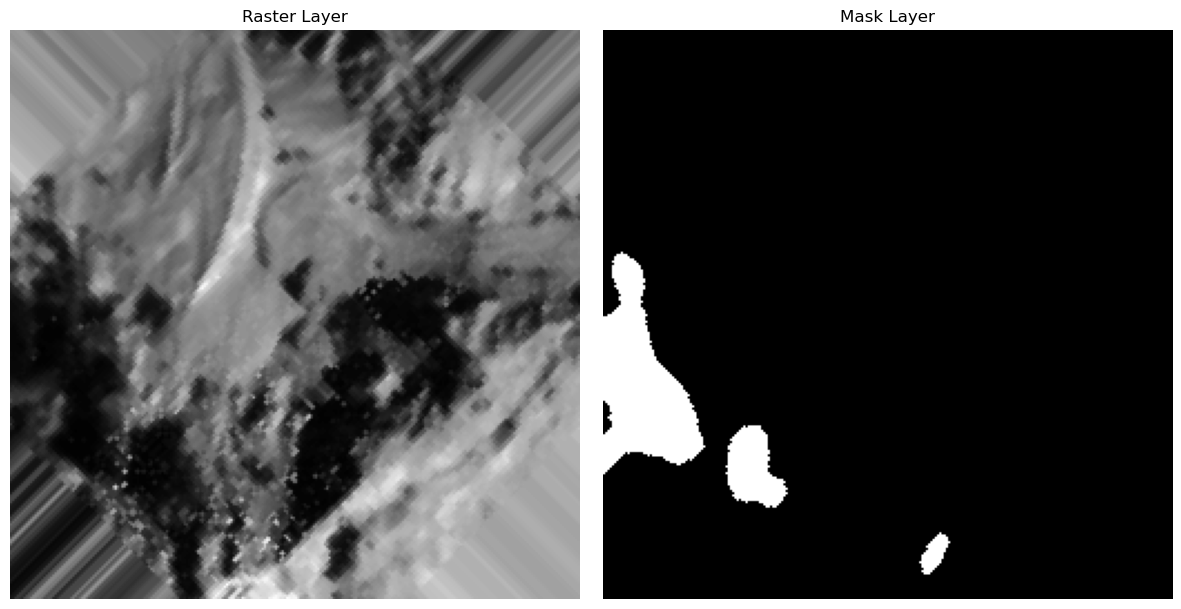

Number of bands in raster: 6


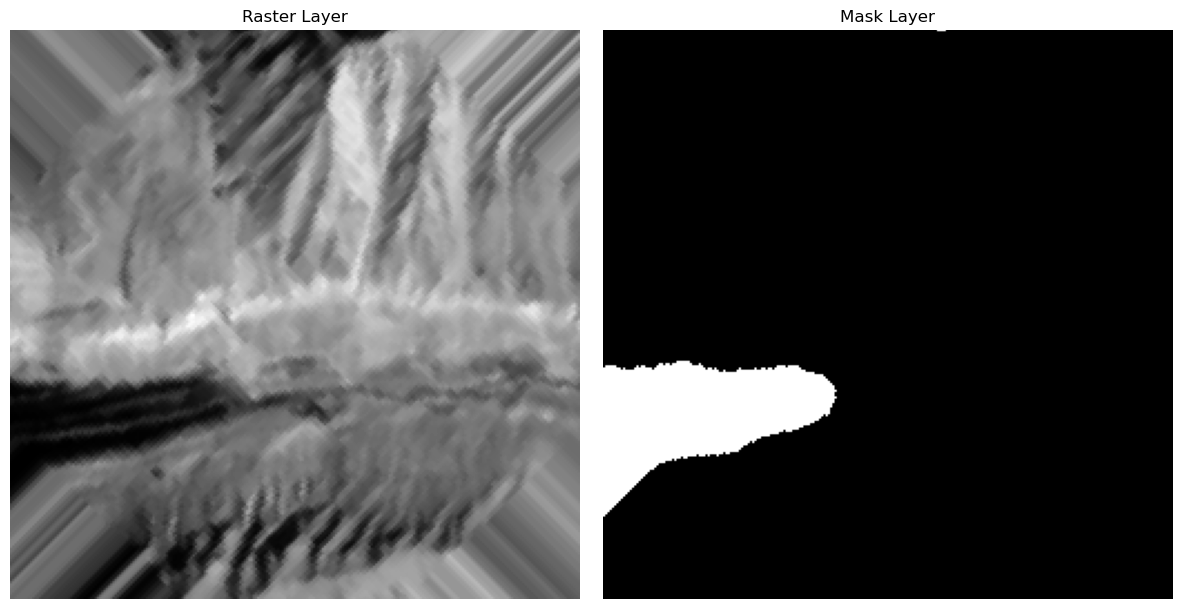

Number of bands in raster: 6


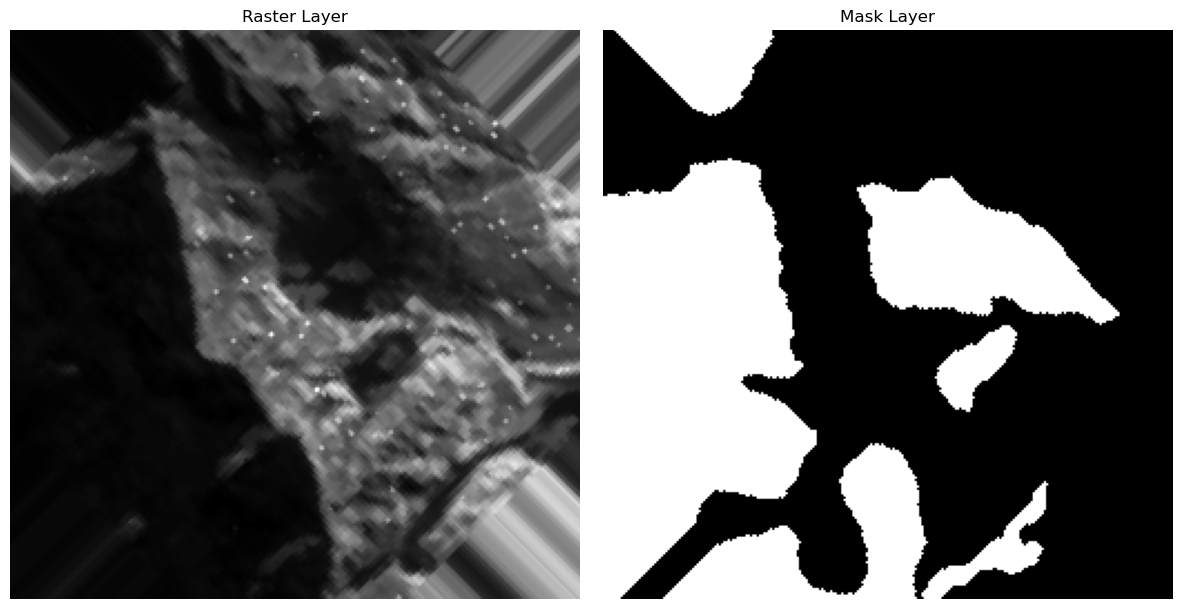

Number of bands in raster: 6


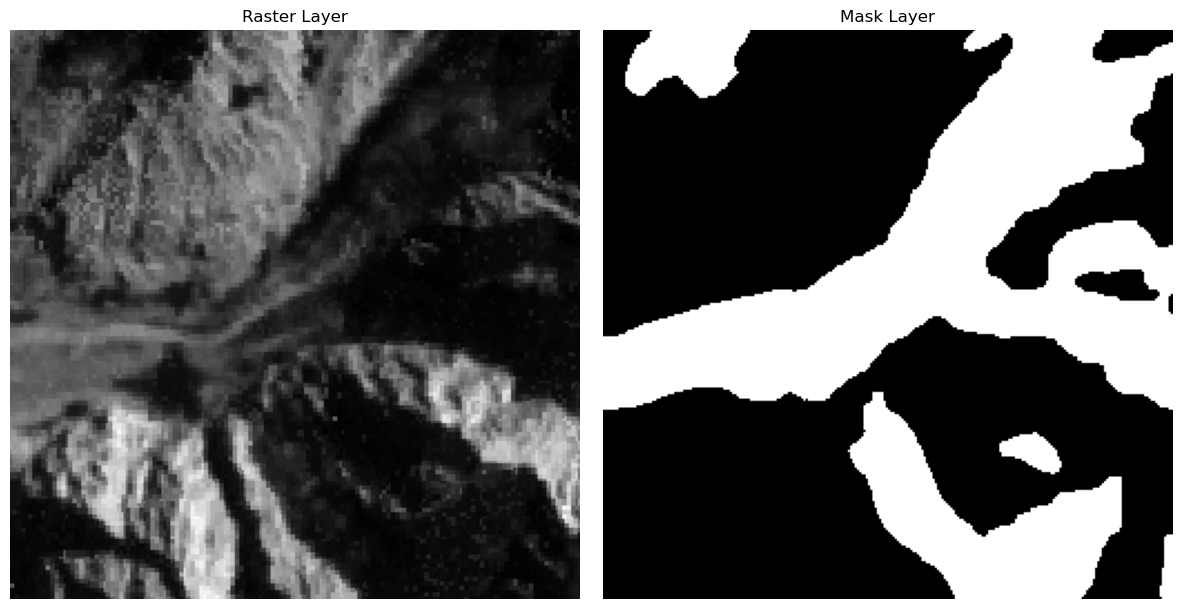

In [8]:
import os
import random
import rasterio
import matplotlib.pyplot as plt

# Output directories
output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/rasterlayer"
output_mask_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/masklayer"
patch_size = 256

# Get a list of patch files
raster_files = sorted([f for f in os.listdir(output_raster_dir) if f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(output_mask_dir) if f.endswith('.tif')])

# Randomly select 4 unique indices
if len(raster_files) >= 4 and len(mask_files) >= 4:
    random_indices = random.sample(range(len(raster_files)), 4)
else:
    print("Not enough raster or mask files available.")
    random_indices = []

# Visualization function for raster and mask
def visualize_layers(raster_file, mask_file):
    with rasterio.open(raster_file) as src_raster:
        # Check the number of bands in the raster
        num_bands = src_raster.count
        print(f"Number of bands in raster: {num_bands}")  # Debugging line

        # Select the first band (ensure it's the correct band)
        raster_data = src_raster.read(1)  # Change this if you want a different band

    with rasterio.open(mask_file) as src_mask:
        mask_data = src_mask.read(1)  # Read the first band (or layer)

    # Create a figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot raster
    ax[0].imshow(raster_data, cmap='gray')
    ax[0].set_title('Raster Layer')
    ax[0].axis('off')  # Hide axis

    # Plot mask
    ax[1].imshow(mask_data, cmap='gray')
    ax[1].set_title('Mask Layer')
    ax[1].axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

# Visualize the selected random patches
for index in random_indices:
    visualize_layers(os.path.join(output_raster_dir, raster_files[index]),
                     os.path.join(output_mask_dir, mask_files[index]))

In [9]:
import os
import rasterio
import numpy as np

output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/rasterlayer"
output_mask_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/masklayer"

# Function to check if a file is a valid raster
def is_valid_raster(file_path):
    try:
        with rasterio.open(file_path) as src:
            return True
    except:
        return False

# Function to load patches and calculate metrics
def load_and_calculate_metrics(raster_dir, mask_dir):
    raster_files = sorted([f for f in os.listdir(raster_dir) if is_valid_raster(os.path.join(raster_dir, f))])
    mask_files = sorted([f for f in os.listdir(mask_dir) if is_valid_raster(os.path.join(mask_dir, f))])

    if not raster_files or not mask_files:
        print("No valid raster or mask files found.")
        return

    # Load first raster file to extract dimensions
    with rasterio.open(os.path.join(raster_dir, raster_files[0])) as src:
        raster_height = src.height
        raster_width = src.width
        raster_channels = src.count

    # Count the number of patches
    raster_length = len(raster_files)
    mask_length = len(mask_files)

    # Check for the total classes in the mask
    mask_classes = set()

    for mask_file in mask_files:
        with rasterio.open(os.path.join(mask_dir, mask_file)) as mask_src:
            mask_data = mask_src.read(1)  # Read the first band
            mask_classes.update(np.unique(mask_data))

    # Print the calculated metrics
    print("Length of raster dataset:", raster_length)
    print("Length of mask dataset:", mask_length)
    print("Raster height:", raster_height)
    print("Raster width:", raster_width)
    print("Raster channels:", raster_channels)
    print("Total classes of mask (1 for glacier, 0 for non-glacier):", sorted(mask_classes))

# Call the function to load datasets and calculate metrics
load_and_calculate_metrics(output_raster_dir, output_mask_dir)

Length of raster dataset: 2230
Length of mask dataset: 2230
Raster height: 256
Raster width: 256
Raster channels: 6
Total classes of mask (1 for glacier, 0 for non-glacier): [0, 1]


In [10]:
output_raster_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/rasterlayer"
output_mask_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/masklayer"
patch_size = 256  # Ensure your patches match your input shape

# Function to load raster dataset
def load_raster_dataset(directory):
    image_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                image_data = src.read()
                image_list.append(image_data)
    return np.stack(image_list, axis=0) if image_list else np.array([])

In [11]:
# Function to load mask dataset
def load_mask_dataset(directory):
    mask_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            file_path = os.path.join(directory, filename)
            with rasterio.open(file_path) as src:
                mask_data = src.read(1)
                mask_list.append(mask_data)
    return np.stack(mask_list, axis=0) if mask_list else np.array([])

# Load datasets
image_dataset = load_raster_dataset(output_raster_dir)
mask_dataset = load_mask_dataset(output_mask_dir)

# Transpose image dataset to have channels last
image_dataset = np.transpose(image_dataset, (0, 2, 3, 1))

# Normalize image data
#image_dataset = image_dataset.astype('float32') / 255.0

# Convert mask to categorical
unique_labels = np.unique(mask_dataset)
total_classes = len(unique_labels)
mask_dataset_cat = to_categorical(mask_dataset, num_classes=total_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_cat, test_size=0.01, random_state=100
)

In [14]:
# Define U-Net Plus Plus model
def jaccard_coef(y_true, y_pred):
    y_true_flatten = tf.keras.backend.flatten(y_true)
    y_pred_flatten = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.keras.backend.sum(y_true_flatten) + tf.keras.backend.sum(y_pred_flatten) - intersection + 1.0)
    return final_coef_value

def conv_block(inputs, filters, dropout=0.2):
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    return x

def unet_plus_plus(n_classes=1, input_shape=(64, 64, 1)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Nested and dense skip connections
    u4_1 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u4_1 = tf.keras.layers.concatenate([u4_1, c4])
    c4_1 = conv_block(u4_1, 512)

    u3_2 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4_1)
    u3_2 = tf.keras.layers.concatenate([u3_2, c3])
    c3_2 = conv_block(u3_2, 256)

    u2_3 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3_2)
    u2_3 = tf.keras.layers.concatenate([u2_3, c2])
    c2_3 = conv_block(u2_3, 128)

    u1_4 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c2_3)
    u1_4 = tf.keras.layers.concatenate([u1_4, c1])
    c1_4 = conv_block(u1_4, 64)

    # Output layer
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c1_4)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [15]:
import tensorflow as tf

def jaccard_coef(y_true, y_pred):
    # Ensure both y_true and y_pred are float32 using tf.cast
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Flatten the inputs
    y_true_flatten = tf.reshape(y_true, [-1])
    y_pred_flatten = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_flatten * y_pred_flatten)
    final_coef_value = (intersection + 1.0) / (tf.reduce_sum(y_true_flatten) + tf.reduce_sum(y_pred_flatten) - intersection + 1.0)
    
    return final_coef_value

In [17]:
model = unet_plus_plus(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), n_classes=total_classes)
dice_loss = sm.losses.DiceLoss(class_weights=[0.3, 0.7])
#dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(optimizer=Adam(), loss=total_loss, metrics=["accuracy", jaccard_coef])

In [18]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster GPU computation
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Path to save the model
model_save_path = 'sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5'

#Increased Learning Rate for Faster Training
learning_rate = 1e-3  

#Use Adam Optimizer with New Learning Rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A4000, compute capability 8.6


In [19]:
# Model checkpoint callback (save the best model)
model_checkpoint = ModelCheckpoint(
    model_save_path, 
    save_best_only=True,  
    monitor='val_loss',   
    mode='min',           
    verbose=1            
)

# Increase batch size to fully utilize GPU
batch_size = 8

# Train the model with mixed precision and improved performance
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1000,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000


2025-08-19 19:46:38.106119: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-08-19 19:46:38.598238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-08-19 19:46:38.713286: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-19 19:46:39.042543: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-19 19:46:40.922859: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3446db10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-19 19:46:40.922916: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.

276/276 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.8547
Epoch 1: val_loss improved from inf to 0.30571, saving model to sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5


/home/sarvesh/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


276/276 [==============================] - 77s 220ms/step - loss: 1.1303 - accuracy: 0.8547 - val_loss: 0.3057 - val_accuracy: 0.8654
Epoch 2/1000
276/276 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9019
Epoch 2: val_loss improved from 0.30571 to 0.29756, saving model to sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5
276/276 [==============================] - 61s 220ms/step - loss: 0.2375 - accuracy: 0.9019 - val_loss: 0.2976 - val_accuracy: 0.8877
Epoch 3/1000
276/276 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9111
Epoch 3: val_loss improved from 0.29756 to 0.26349, saving model to sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5
276/276 [==============================] - 63s 229ms/step - loss: 0.2185 - accuracy: 0.9111 - val_loss: 0.2635 - val_accuracy: 0.8920
Epoch 4/1000
276/276 [==============================] - ETA: 0s - loss: 0.2078 - accuracy: 0.9161
Epoch 4: val_loss improved f

In [20]:
tf.keras.backend.clear_session()

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output.shape)

X_train shape: (2207, 256, 256, 6)
y_train shape: (2207, 256, 256, 2)
Model output shape: (None, 256, 256, 2)


In [22]:
# Check model output shape at different stages
print("Model output shape:", model.output.shape)

# Check the shape of y_train
print("Training labels shape:", y_train.shape)

Model output shape: (None, 256, 256, 2)
Training labels shape: (2207, 256, 256, 2)


Text(0.5, 1.0, 'Model Accuracy')

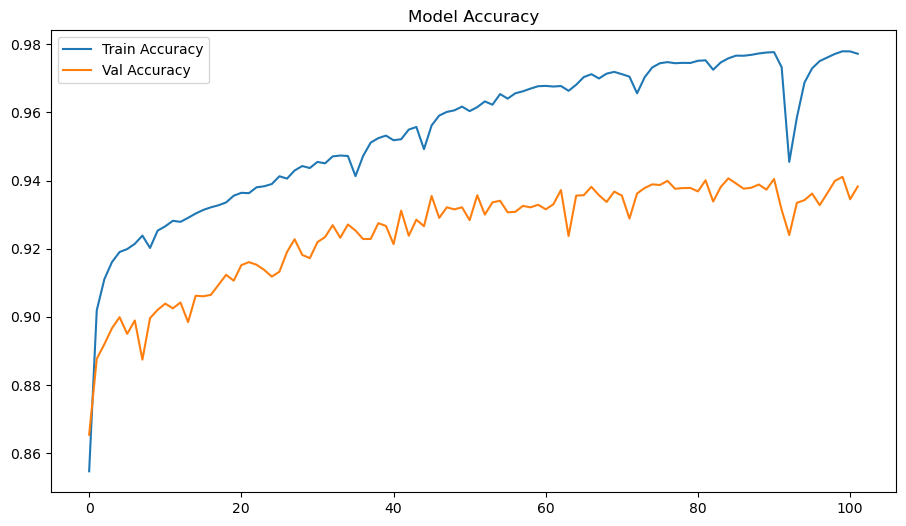

In [23]:
# Plot training results
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

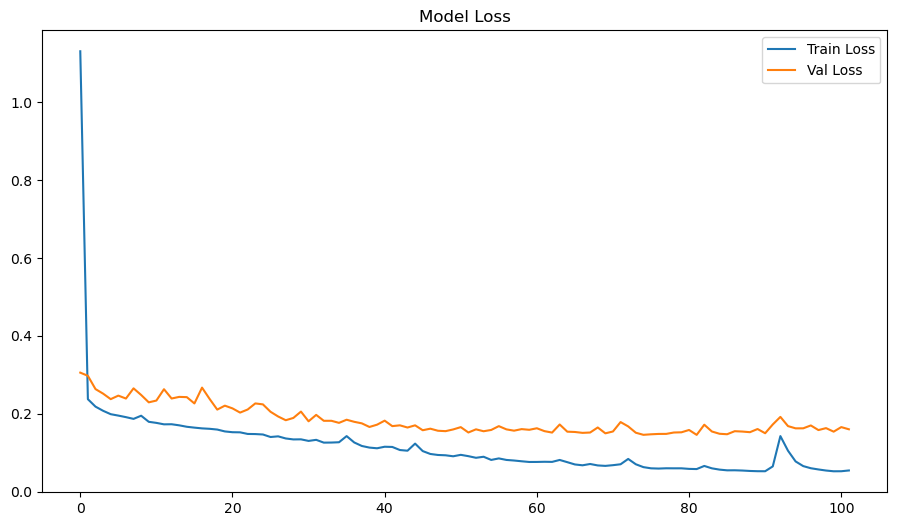

In [24]:
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [25]:
#Predict on the test set
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

1/1 [==============================] - 5s 5s/step


In [26]:
# Convert y_test to argmax for comparison
y_test_argmax = np.argmax(y_test, axis=3)

In [27]:
# Select a random test image for prediction visualization
test_image_number = random.randint(0, len(X_test) - 1)

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

1/1 [==============================] - 0s 43ms/step


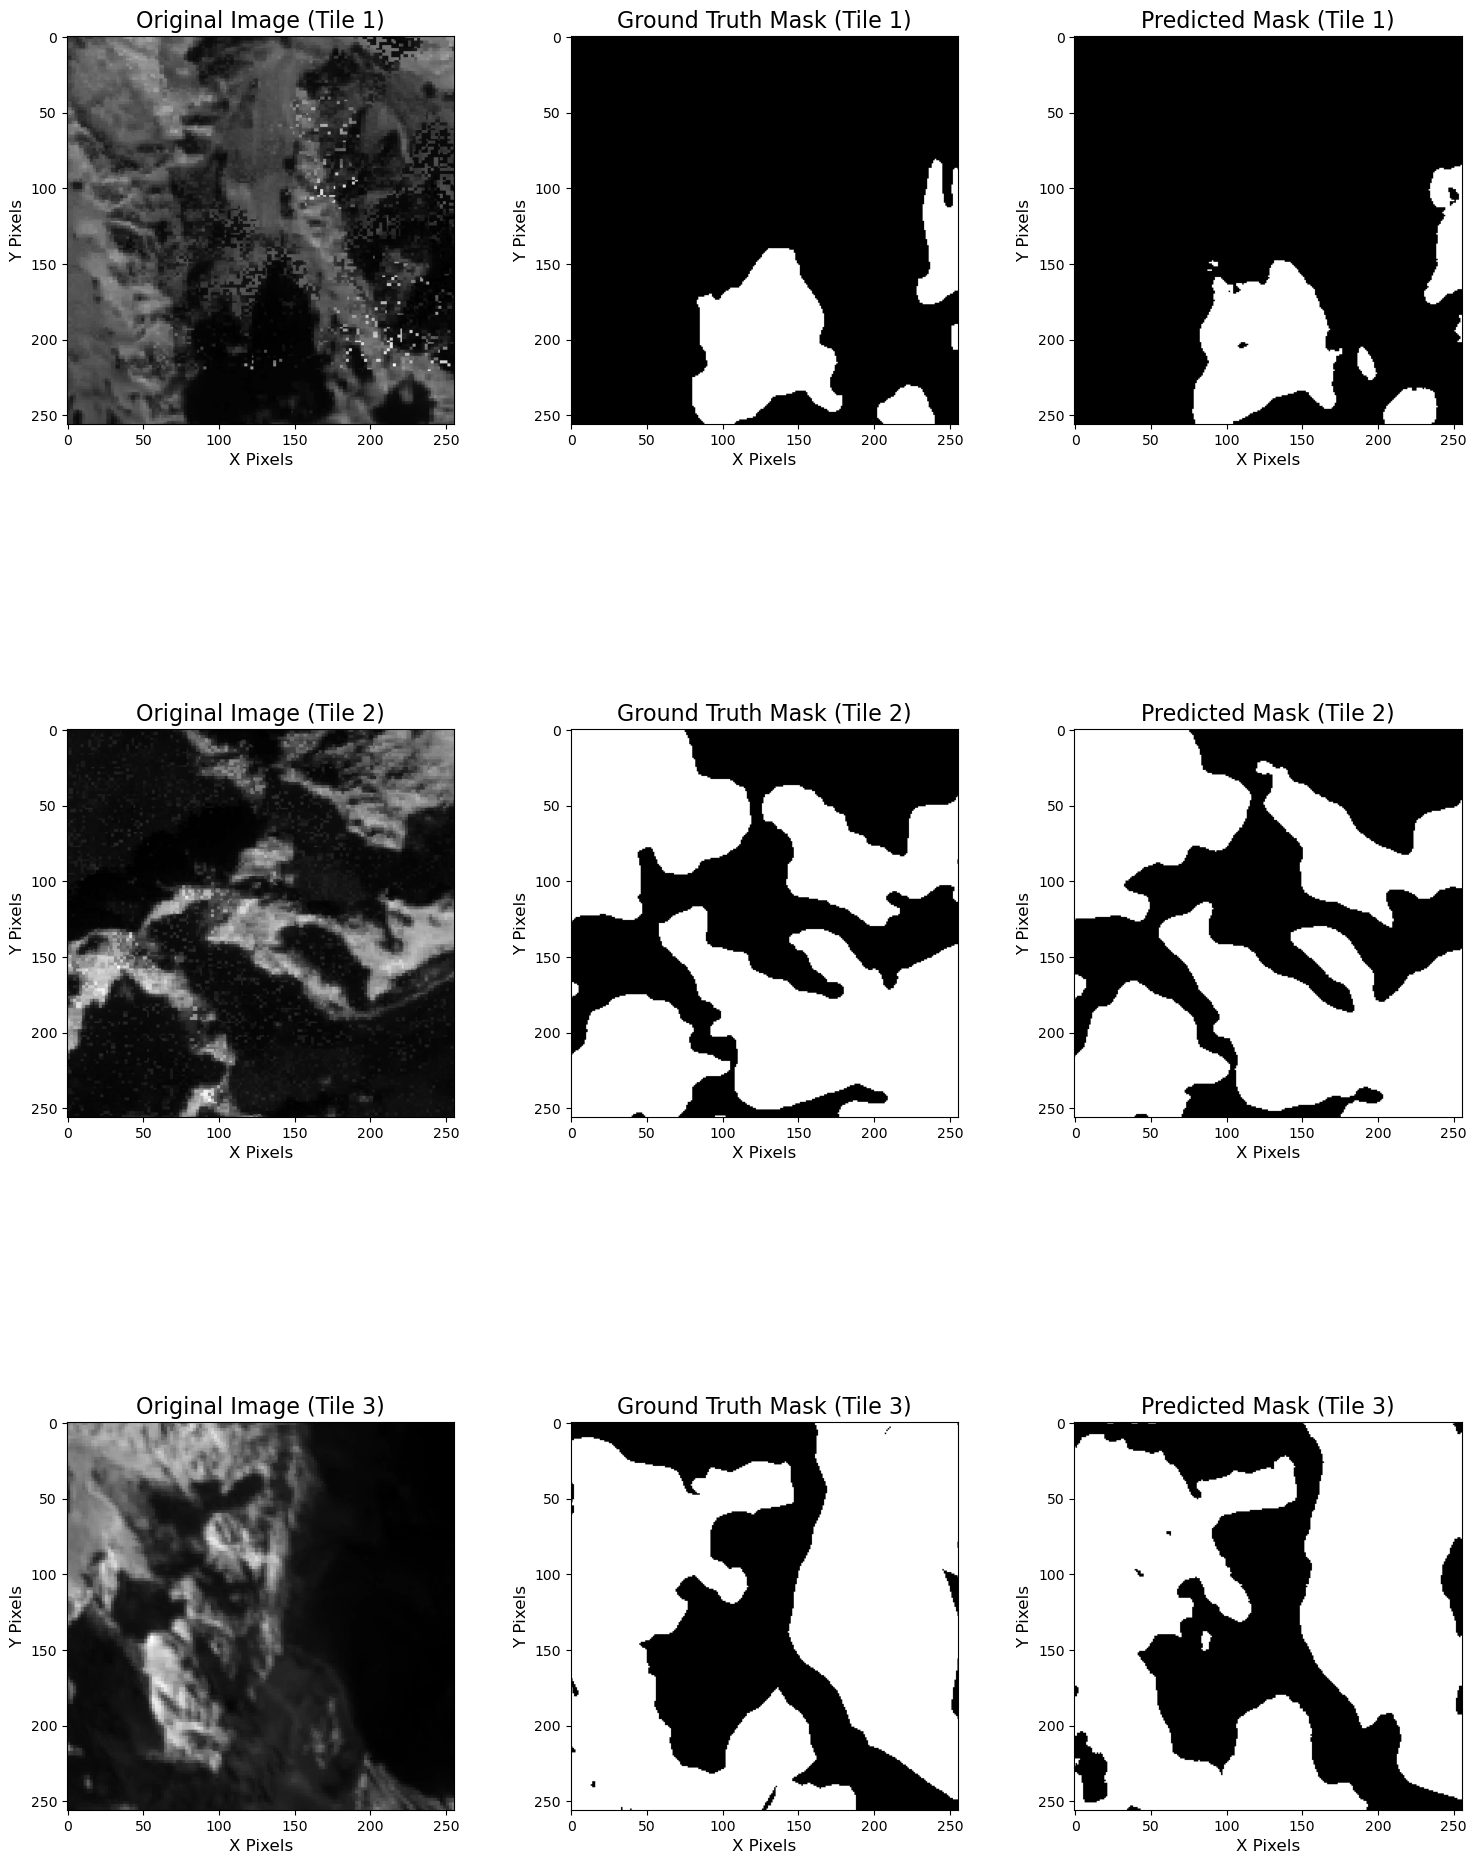

In [28]:
# Define the figure size and the spacing between subplots
plt.figure(figsize=(18, 24))  # Adjusted size for three rows
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increased spacing between plots and rows

# Loop through the first three tiles in the test set
for i in range(3):
    test_image = X_test[i]
    ground_truth_image = np.argmax(y_test[i], axis=-1)  # Decategorize the mask
    predicted_mask = model.predict(np.expand_dims(test_image, axis=0))
    predicted_image = np.argmax(predicted_mask[0], axis=-1)  # Decategorize predicted mask

    # Original Image
    plt.subplot(3, 3, i * 3 + 1)
    plt.title(f"Original Image (Tile {i+1})", fontsize=16)
    plt.imshow(test_image[..., 0], cmap='gray')  # Show first channel only
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Ground Truth Mask
    plt.subplot(3, 3, i * 3 + 2)
    plt.title(f"Ground Truth Mask (Tile {i+1})", fontsize=16)
    plt.imshow(ground_truth_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

    # Predicted Mask
    plt.subplot(3, 3, i * 3 + 3)
    plt.title(f"Predicted Mask (Tile {i+1})", fontsize=16)
    plt.imshow(predicted_image, cmap='gray')
    plt.xlabel("X Pixels", fontsize=12)
    plt.ylabel("Y Pixels", fontsize=12)

# Show the plot
plt.show()

In [29]:
from tensorflow.keras.models import load_model

# Load the model with custom objects
model_path = 'sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5'
# Load the model (no custom objects used)
model = load_model(model_path, compile=False)

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 6)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         3520      ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 64)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 64)         36928     ['dropout_9[0][0]']           
                                                                                            

In [30]:
import rasterio
import numpy as np
import os

# Input raster file paths
raster_files = [
    "sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif",
    "sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif",
    "sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif",
    "sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif"
]

# Output directory for filtered rasters
output_dir = "sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters"
os.makedirs(output_dir, exist_ok=True)

# Top 6 contributing bands (1-based indices)
top_6_bands = [5, 17, 1, 2, 16, 7]

# Process each raster file
for raster_path in raster_files:
    with rasterio.open(raster_path) as src:
        num_bands = src.count
        selected_bands = [b for b in top_6_bands if b <= num_bands]

        # Read and stack the selected bands
        selected_data = np.stack([src.read(b) for b in selected_bands])

        # Output file name
        output_filename = os.path.join(
            output_dir,
            os.path.basename(raster_path).replace(".tif", "_6band.tif")
        )

        # Write filtered raster
        with rasterio.open(
            output_filename, 'w', driver='GTiff',
            height=src.height, width=src.width,
            count=len(selected_bands), dtype=src.dtypes[0],
            crs=src.crs, transform=src.transform
        ) as dst:
            dst.write(selected_data)

        print(f"Processed: {raster_path} → Saved: {output_filename}")

print("Top 6 band filtering complete!")

Processed: sarvesh/DATASETS_NORMALIZED/raster_cb__normalized.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/raster_cb__normalized_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/cb_vali_normalized_128.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/cb_vali_normalized_128_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/sikkim_chaudhary_255_final.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/sikkim_chaudhary_255_final_6band.tif
Processed: sarvesh/DATASETS_NORMALIZED/KASHMIR_NORMALIZED_255_final.tif → Saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/KASHMIR_NORMALIZED_255_final_6band.tif
Top 6 band filtering complete!


In [31]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from rasterio.features import shapes
import fiona
from shapely.geometry import shape, mapping
import os

# Define paths
model_path = 'sarvesh/sato_new/sato_sikkim_kashmir/top6/model/unet_sato_all_top6.h5'
raster_files = [
    'sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/sikkim_chaudhary_255_final_6band.tif',
    'sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/KASHMIR_NORMALIZED_255_final_6band.tif',
    'sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/raster_cb__normalized_6band.tif',
    'sarvesh/sato_new/sato_sikkim_kashmir/top6/top6_rasters/cb_vali_normalized_128_6band.tif',
    'sarvesh/sato_new/sato_sikkim_kashmir/top6/NEW_UK_TIF_fixedB10_6band_all.tif'
]
output_dir = 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6'

# Load the model
model = load_model(model_path, compile=False)

# Patch and overlap settings
patch_size = 256
overlap = 128
stride = patch_size - overlap

# Blending matrix
blend_matrix = np.ones((patch_size, patch_size))
for i in range(overlap):
    weight = (i + 1) / overlap
    blend_matrix[i, :] *= weight
    blend_matrix[-(i + 1), :] *= weight
    blend_matrix[:, i] *= weight
    blend_matrix[:, -(i + 1)] *= weight

# Process each raster file
for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        raster_data = src.read()
        raster_profile = src.profile
        transform = src.transform
        crs = src.crs

    # Transpose raster to (H, W, C)
    raster_data = np.transpose(raster_data, (1, 2, 0))
    height, width, channels = raster_data.shape

    # Pad raster
    pad_h = (stride - height % stride) % stride
    pad_w = (stride - width % stride) % stride
    raster_data_padded = np.pad(raster_data, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')

    # Predict full raster via sliding window
    predicted_raster = np.zeros((raster_data_padded.shape[0], raster_data_padded.shape[1]), dtype=np.float32)
    weight_sum = np.zeros_like(predicted_raster)

    for i in range(0, raster_data_padded.shape[0] - patch_size + 1, stride):
        for j in range(0, raster_data_padded.shape[1] - patch_size + 1, stride):
            patch = raster_data_padded[i:i + patch_size, j:j + patch_size, :]
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch, verbose=0)
            predicted_patch = np.argmax(prediction, axis=-1).squeeze()

            predicted_raster[i:i + patch_size, j:j + patch_size] += predicted_patch * blend_matrix
            weight_sum[i:i + patch_size, j:j + patch_size] += blend_matrix

    # Normalize and crop
    weight_sum[weight_sum == 0] = 1
    predicted_raster = (predicted_raster / weight_sum).astype(np.uint8)
    predicted_raster = predicted_raster[:height, :width]

    # Save predicted raster
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(raster_file))[0]
    predicted_raster_path = os.path.join(output_dir, f'{base_name}_sato_top6_unet.tif')

    raster_profile.update({
        'count': 1,
        'dtype': 'uint8',
        'compress': 'lzw',
        'nodata': 0
    })

    with rasterio.open(predicted_raster_path, 'w', **raster_profile) as dst:
        dst.write(predicted_raster, 1)

    print(f"Predicted raster saved: {predicted_raster_path}")

    # Convert raster to shapefile
    shapefile_path = os.path.join(output_dir, f'{base_name}_sato_top6_unet.shp')
    shapes_gen = shapes(predicted_raster, mask=predicted_raster > 0, transform=transform)

    schema = {
        'geometry': 'Polygon',
        'properties': {'value': 'int'}
    }

    with fiona.open(shapefile_path, 'w', driver='ESRI Shapefile', crs=crs, schema=schema) as shp:
        for geom, value in shapes_gen:
            shp.write({
                'geometry': mapping(shape(geom)),
                'properties': {'value': int(value)}
            })

    print(f"Shapefile saved: {shapefile_path}")

Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/sikkim_chaudhary_255_final_6band_sato_top6_unet.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/sikkim_chaudhary_255_final_6band_sato_top6_unet.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/KASHMIR_NORMALIZED_255_final_6band_sato_top6_unet.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/KASHMIR_NORMALIZED_255_final_6band_sato_top6_unet.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/raster_cb__normalized_6band_sato_top6_unet.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/raster_cb__normalized_6band_sato_top6_unet.shp
Predicted raster saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/cb_vali_normalized_128_6band_sato_top6_unet.tif
Shapefile saved: sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/cb_vali_normalized_128_6band_sato_top6_unet.shp
Predicted raster saved: sarvesh/sa


=== Processing CB VALIDATION ===
Confusion Matrix:
[[20198723   196815]
 [  516620  2019506]]
Overall Accuracy: 0.9689
Mean IoU: 0.8524
F1 Score: 0.9163
Recall: 0.8933
Precision: 0.9431
Cohen's Kappa: 0.8326

=== Processing uk ===
Confusion Matrix:
[[13531726   181986]
 [  438696  4588327]]
Overall Accuracy: 0.9669
Mean IoU: 0.9185
F1 Score: 0.9571
Recall: 0.9497
Precision: 0.9652
Cohen's Kappa: 0.9142

=== Processing KASHMIR ===
Confusion Matrix:
[[23202813    60764]
 [   95861   520522]]
Overall Accuracy: 0.9934
Mean IoU: 0.8810
F1 Score: 0.9329
Recall: 0.9209
Precision: 0.9457
Cohen's Kappa: 0.8659

=== Processing SIKKIM ===
Confusion Matrix:
[[18495146   284905]
 [   77388   426573]]
Overall Accuracy: 0.9812
Mean IoU: 0.7608
F1 Score: 0.8461
Recall: 0.9156
Precision: 0.7977
Cohen's Kappa: 0.6925

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[91387011  3969214]
 [ 1804717 10189888]]
Overall Accuracy: 0.9462
Mean IoU: 0.7894
F1 Score: 0.8743
Recall: 0.9040
Precision: 0.

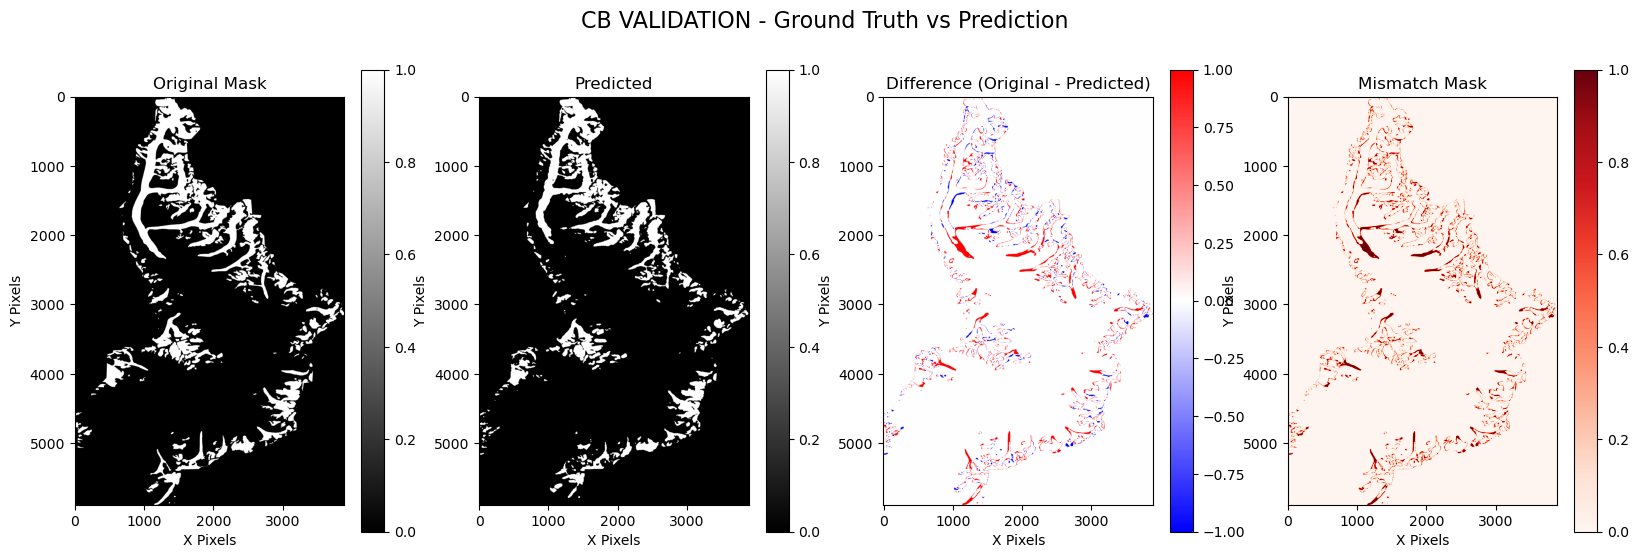

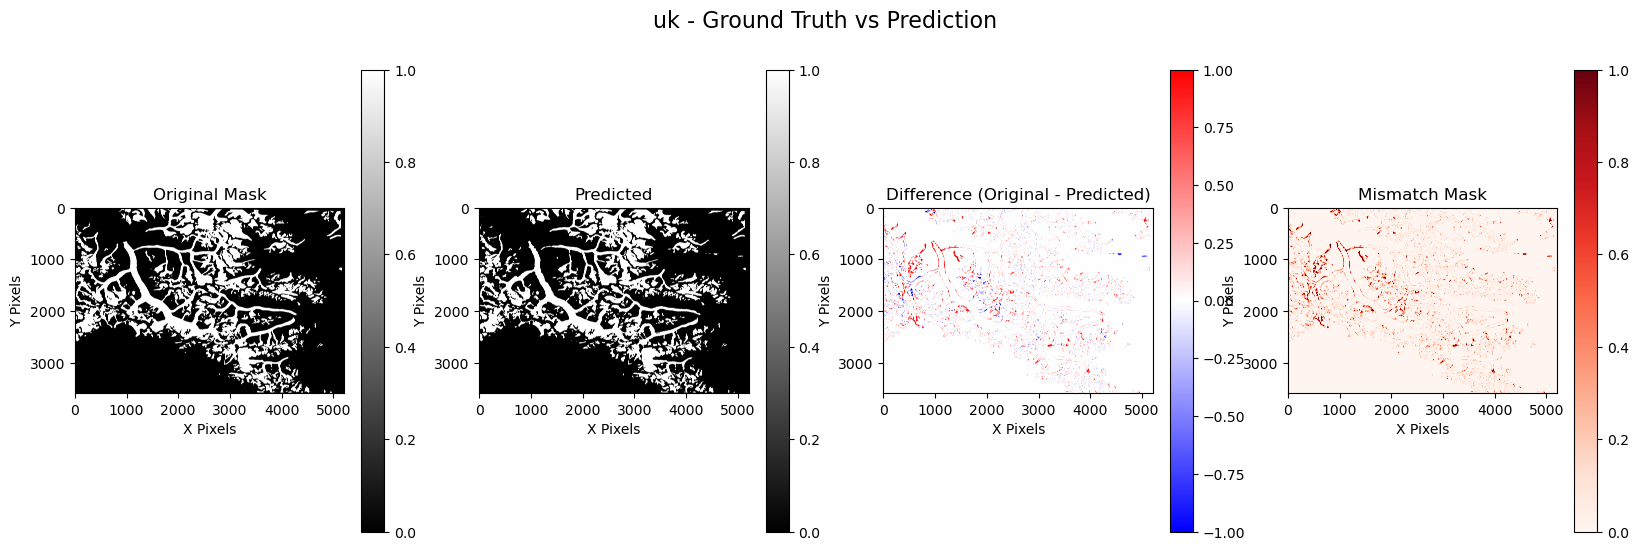

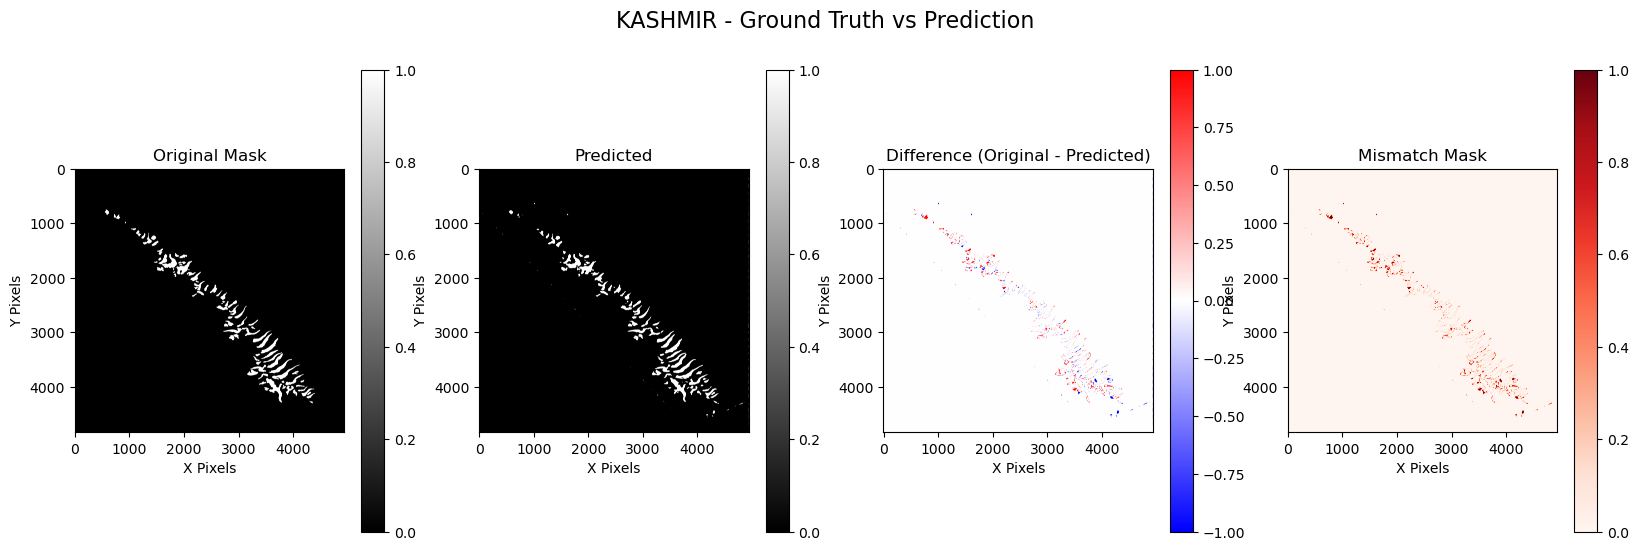

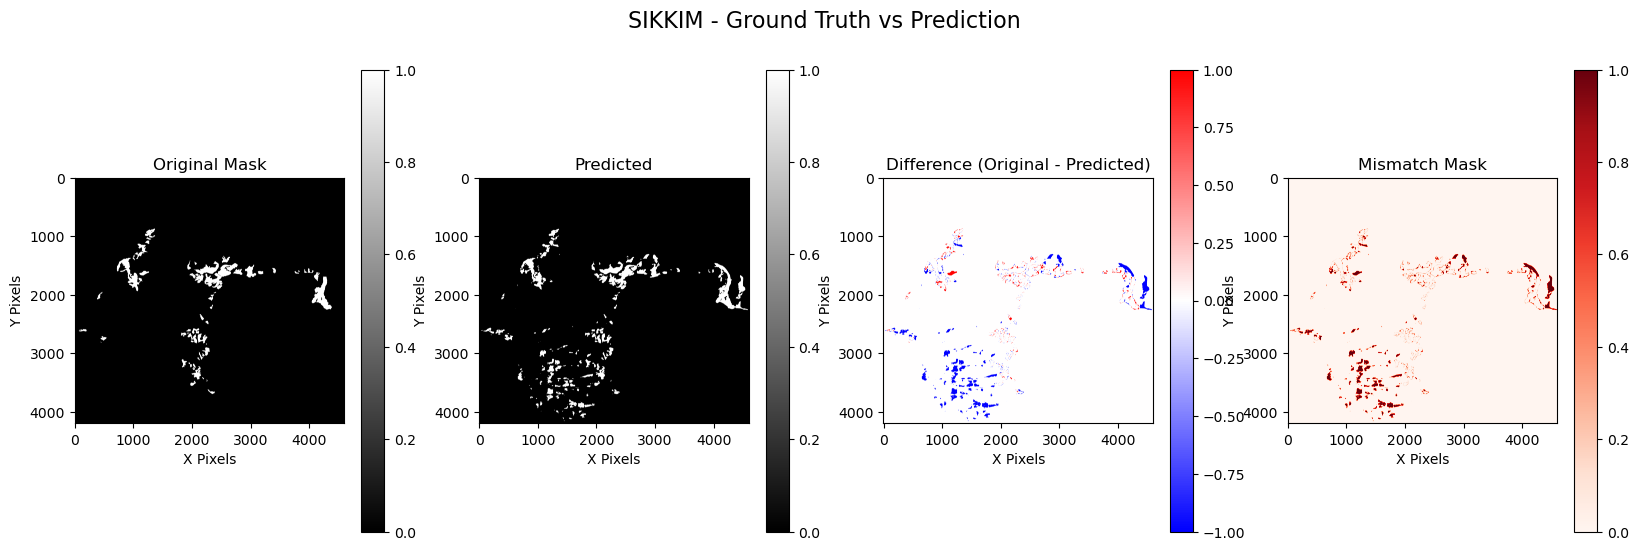

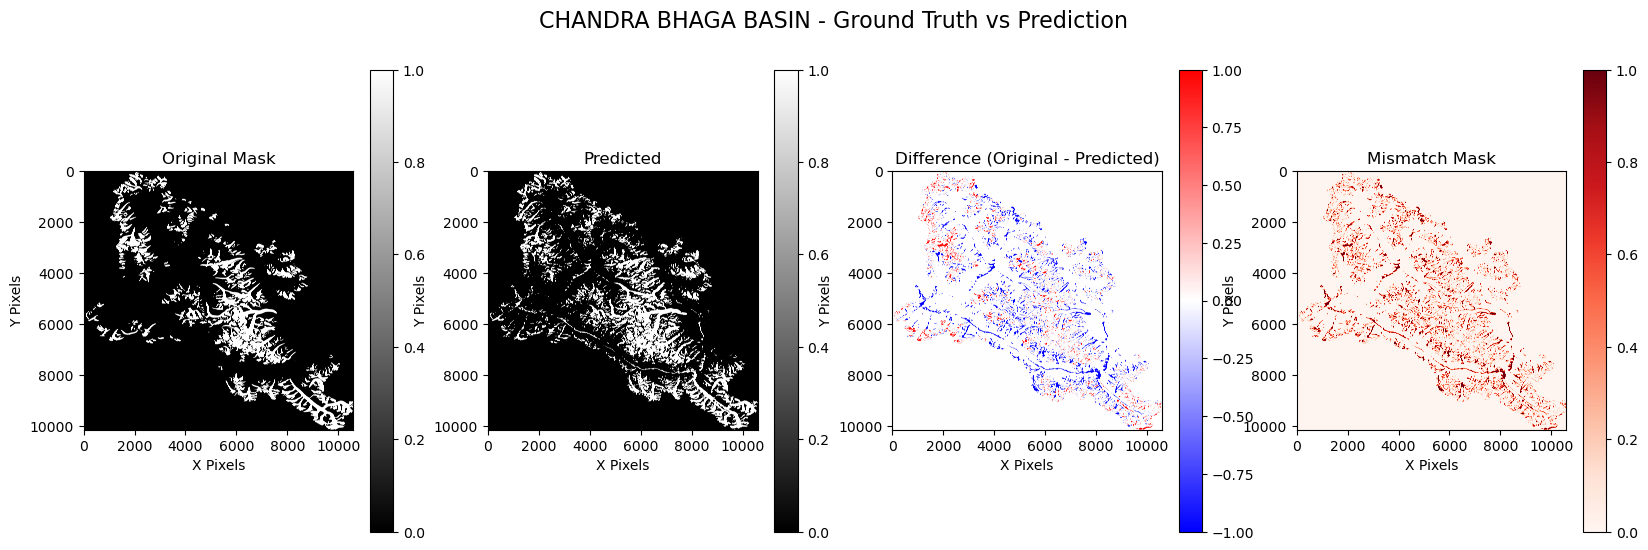

In [34]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling
import os

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/cb_vali_normalized_128_6band_sato_top6_unet.tif',
        'label': 'CB VALIDATION'
    },
    {
        'mask': 'sarvesh/sato_new/glacier_mask_binary.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/NEW_UK_TIF_fixedB10_6band_all_sato_top6_unet.tif',
        'label': 'uk'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/KASHMIR_NORMALIZED_255_final_6band_sato_top6_unet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/sikkim_chaudhary_255_final_6band_sato_top6_unet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/sato_new/sato_sikkim_kashmir/top6/sf_top6/raster_cb__normalized_6band_sato_top6_unet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    }
]

# Loop over each pair
for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load original mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted raster to match original mask dimensions
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    resampled_predicted_valid = resampled_predicted[valid_mask]

    # Compute metrics
    conf_matrix = confusion_matrix(original_mask_valid, resampled_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, resampled_predicted_valid)
    iou = jaccard_score(original_mask_valid, resampled_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, resampled_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, resampled_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, resampled_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, resampled_predicted_valid)

    # Print metrics
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Visualize - create new figure for each dataset
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Ground Truth vs Prediction", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])
    
    # Predicted
    im1 = axes[1].imshow(resampled_predicted, cmap='gray')
    axes[1].set_title("Predicted")
    plt.colorbar(im1, ax=axes[1])
    
    # Difference
    diff = original_mask.astype(int) - resampled_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Original - Predicted)")
    plt.colorbar(im2, ax=axes[2])
    
    # Difference Mask
    diff_mask = (original_mask != resampled_predicted).astype(int)
    im3 = axes[3].imshow(diff_mask, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

# Show all plots at once
plt.show()


=== Processing KASHMIR ===
Confusion Matrix:
[[23263577        0]
 [  603603    12780]]
Overall Accuracy: 0.9747
Mean IoU: 0.4977
F1 Score: 0.5139
Recall: 0.5104
Precision: 0.9874
Cohen's Kappa: 0.0396

=== Processing SIKKIM ===
Confusion Matrix:
[[18780051        0]
 [  236298   267663]]
Overall Accuracy: 0.9877
Mean IoU: 0.7593
F1 Score: 0.8438
Recall: 0.7656
Precision: 0.9938
Cohen's Kappa: 0.6881

=== Processing UTTRAKHAND ===
Confusion Matrix:
[[6221586       0]
 [  35783 2780131]]
Overall Accuracy: 0.9960
Mean IoU: 0.9908
F1 Score: 0.9954
Recall: 0.9936
Precision: 0.9971
Cohen's Kappa: 0.9907

=== Processing CHANDRA BHAGA BASIN ===
Confusion Matrix:
[[95356225        0]
 [ 1981799 10012806]]
Overall Accuracy: 0.9815
Mean IoU: 0.9072
F1 Score: 0.9498
Recall: 0.9174
Precision: 0.9898
Cohen's Kappa: 0.8998

=== Processing CB VALIDATION ===
Confusion Matrix:
[[20395538        0]
 [  420807  2115319]]
Overall Accuracy: 0.9816
Mean IoU: 0.9069
F1 Score: 0.9497
Recall: 0.9170
Precision

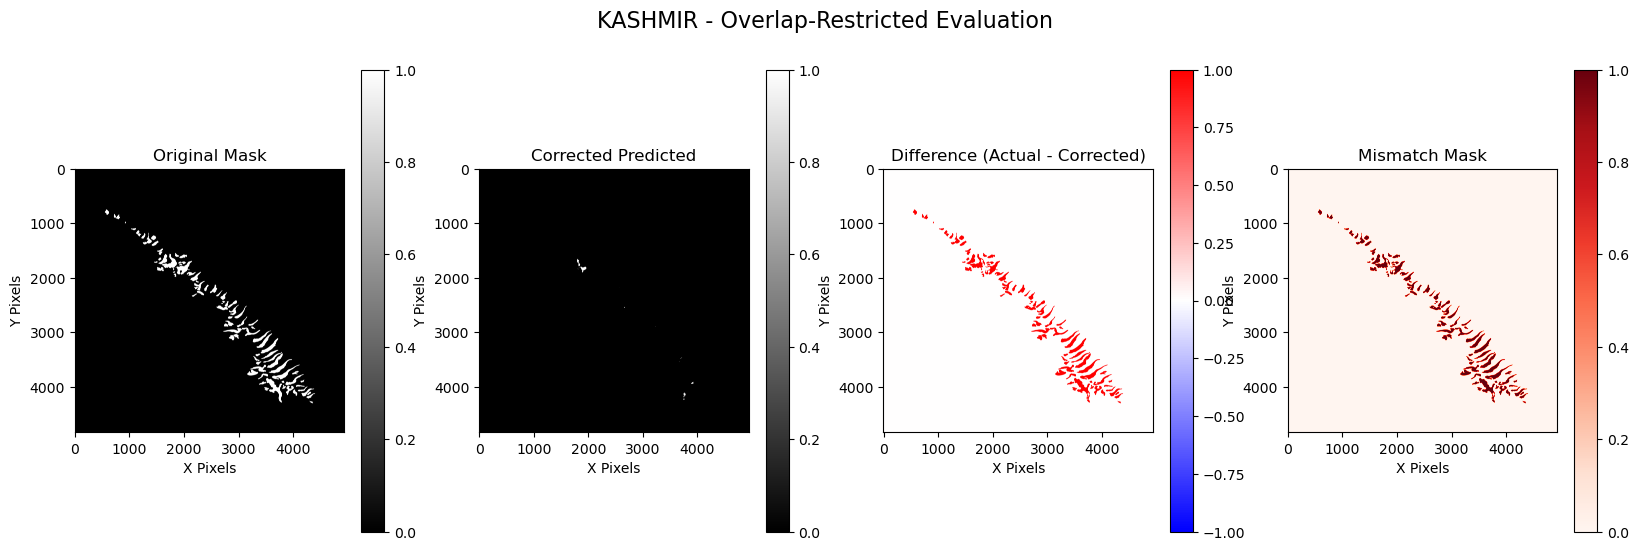

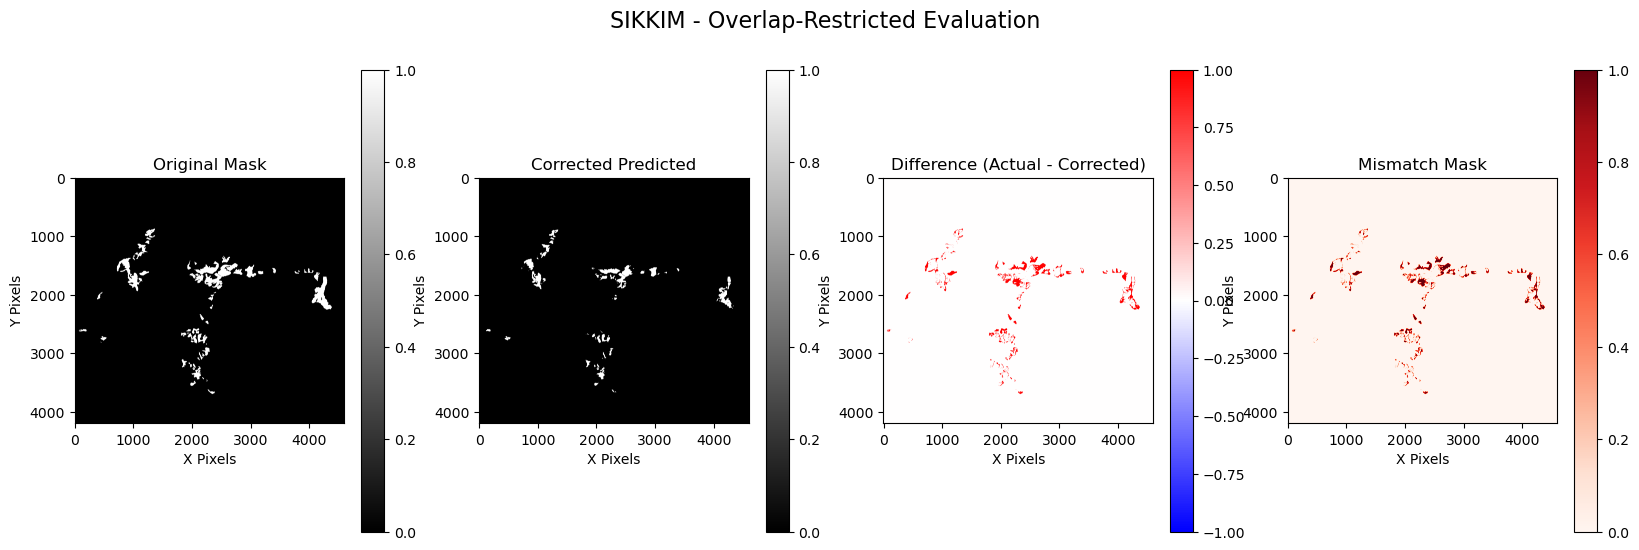

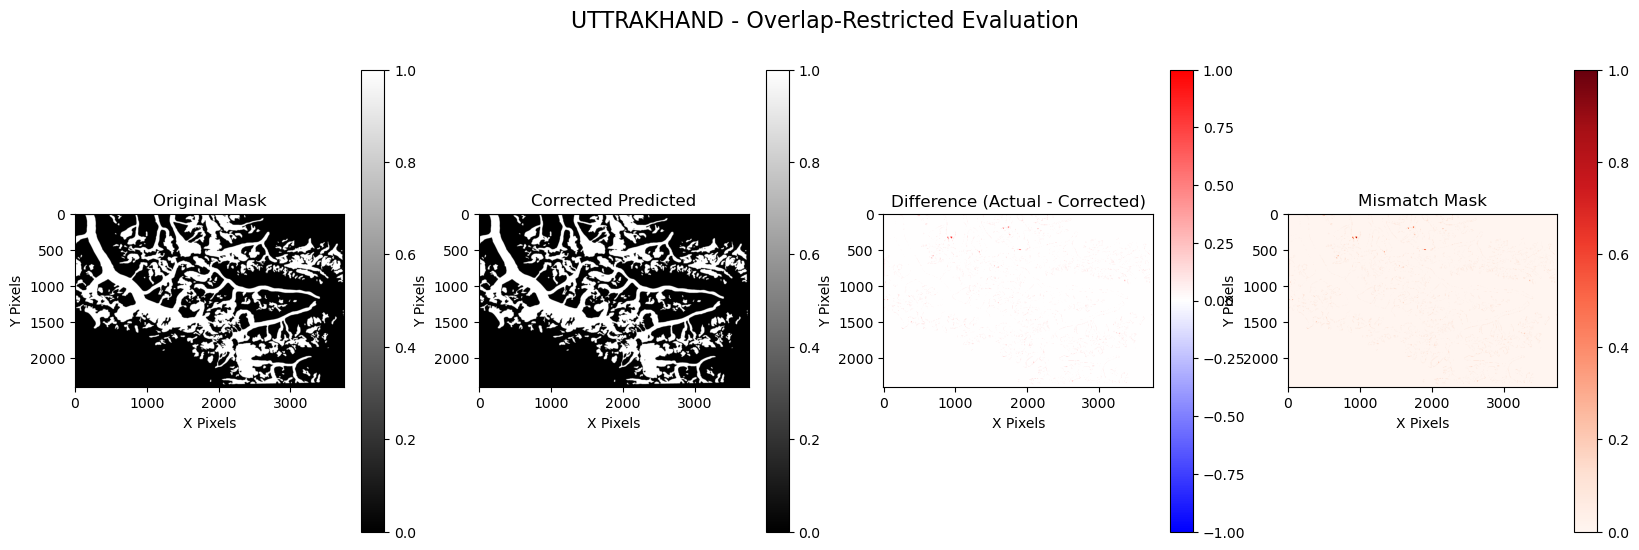

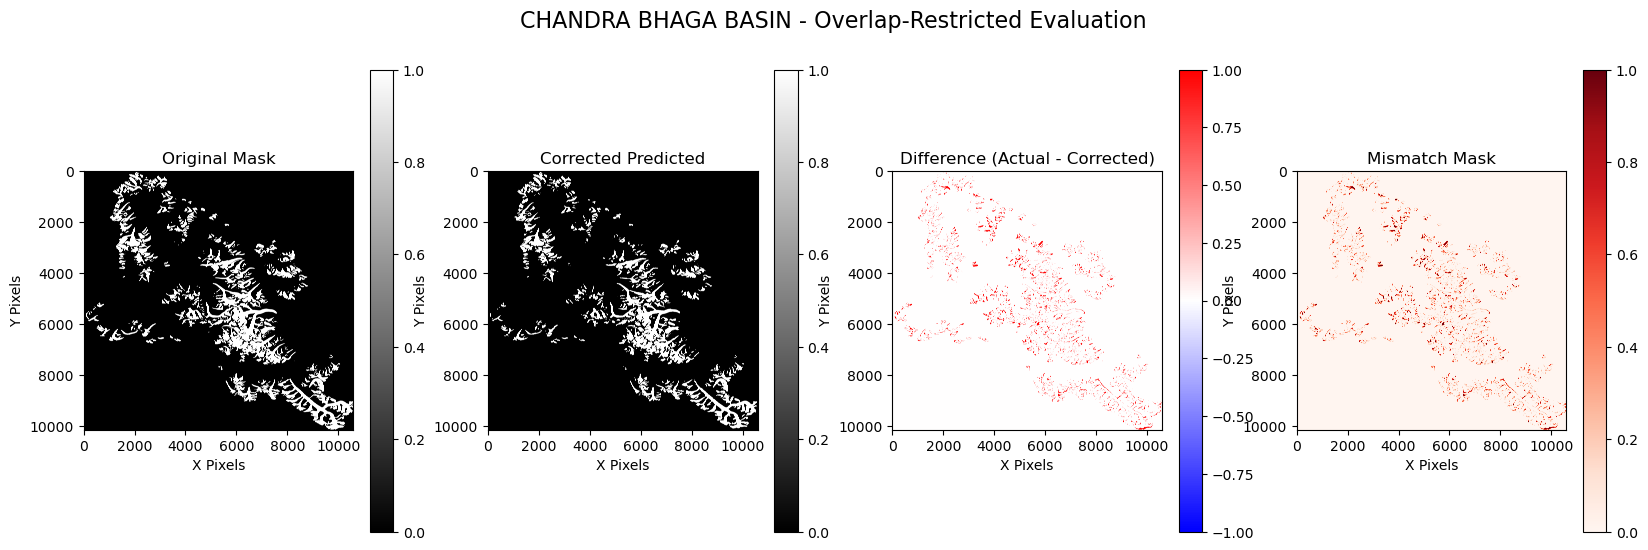

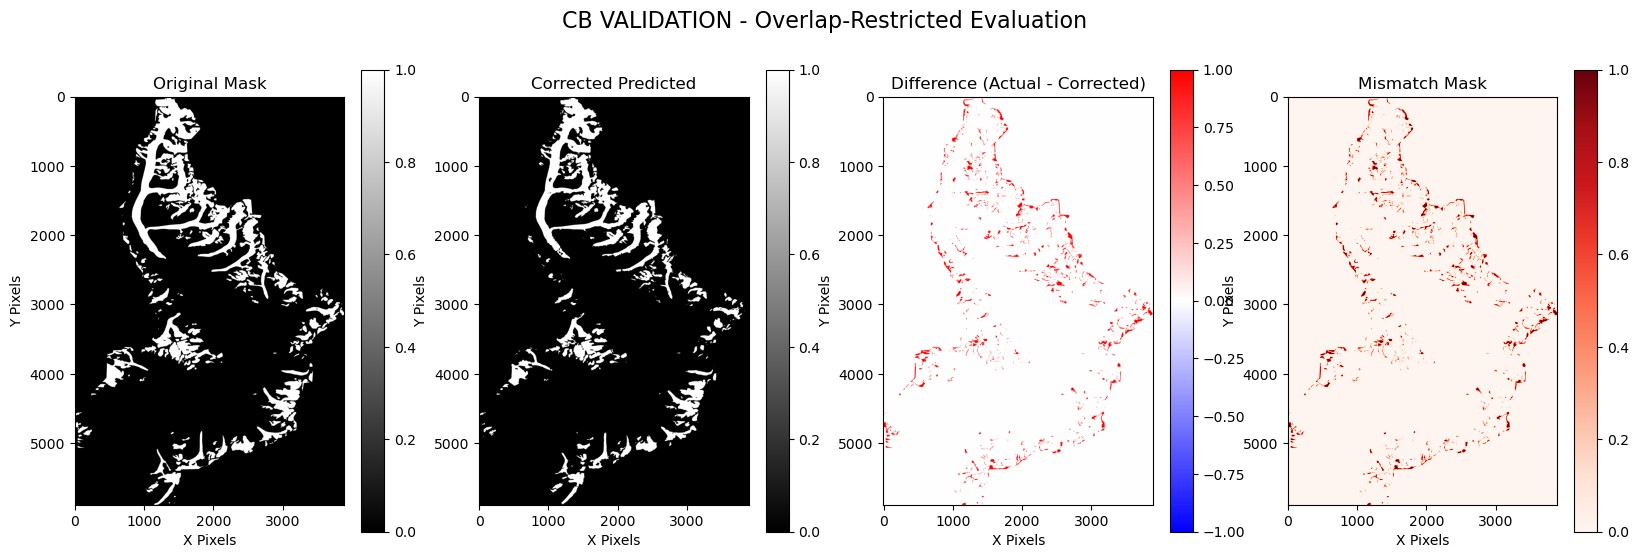

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, jaccard_score, 
    f1_score, recall_score, precision_score, cohen_kappa_score
)
from rasterio.warp import reproject, Resampling

# List of mask and predicted raster paths
data_pairs = [
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/KASHMIR_NORMALIZED_255_finalkasmircomplete_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/unetplus/top6/top6/sf/KASHMIR_NORMALIZED_255_final_6band_cb_segnet.tif',
        'label': 'KASHMIR'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/sikkim_mask.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/unetplus/top6/top6/sf/sikkim_chaudhary_255_final_6band_cb_segnet.tif',
        'label': 'SIKKIM'
    },
    {
        'mask': 'sarvesh/chandrabasin/dataset/new/masklayersato.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/unetplus/top6/top6/sf/raster_satopanth_normalized_6band_cb_segnet.tif',
        'label': 'UTTRAKHAND'
    },
    {
        'mask': 'sarvesh/new_layers_/mask_reprojected/raster_cb__normalized_new_mask_reprojected.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/unetplus/top6/top6/sf/raster_cb__normalized_6band_cb_segnet.tif',
        'label': 'CHANDRA BHAGA BASIN'
    },
    {
        'mask': 'sarvesh/DATASETS_NORMALIZED/CB_VALIDATION_MASK.tif',
        'predicted': 'sarvesh/DATASETS_NORMALIZED/all_sau_net/unetplus/top6/top6/sf/cb_vali_normalized_128_6band_cb_segnet.tif',
        'label': 'CB VALIDATION'
    },
]

for pair in data_pairs:
    print(f"\n=== Processing {pair['label']} ===")

    # Load actual mask
    with rasterio.open(pair['mask']) as src:
        original_mask = src.read(1)
        original_profile = src.profile

    # Load predicted raster
    with rasterio.open(pair['predicted']) as src:
        predicted_raster = src.read(1)

    # Resample predicted to match ground truth mask
    resampled_predicted = np.empty_like(original_mask)
    with rasterio.open(pair['predicted']) as src_pred:
        reproject(
            source=rasterio.band(src_pred, 1),
            destination=resampled_predicted,
            src_transform=src_pred.transform,
            src_crs=src_pred.crs,
            dst_transform=original_profile['transform'],
            dst_crs=original_profile['crs'],
            resampling=Resampling.nearest
        )

    # Handle no-data masking
    nodata_val = original_profile.get('nodata')
    if nodata_val is not None:
        valid_mask = original_mask != nodata_val
    else:
        valid_mask = np.ones_like(original_mask, dtype=bool)

    # === Key step: Remove predictions outside actual mask ===
    # Wherever actual mask is 0, predicted should be set to 0
    corrected_predicted = resampled_predicted.copy()
    corrected_predicted[original_mask == 0] = 0

    # Filter only valid pixels
    original_mask_valid = original_mask[valid_mask]
    corrected_predicted_valid = corrected_predicted[valid_mask]

    # === Accuracy metrics ===
    conf_matrix = confusion_matrix(original_mask_valid, corrected_predicted_valid)
    accuracy = accuracy_score(original_mask_valid, corrected_predicted_valid)
    iou = jaccard_score(original_mask_valid, corrected_predicted_valid, average='macro')
    f1 = f1_score(original_mask_valid, corrected_predicted_valid, average='macro')
    recall = recall_score(original_mask_valid, corrected_predicted_valid, average='macro')
    precision = precision_score(original_mask_valid, corrected_predicted_valid, average='macro')
    kappa = cohen_kappa_score(original_mask_valid, corrected_predicted_valid)

    # Print results
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Mean IoU: {iou:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")

    # === Visualization ===
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    fig.suptitle(f"{pair['label']} - Overlap-Restricted Evaluation", fontsize=16)

    # Original Mask
    im0 = axes[0].imshow(original_mask, cmap='gray')
    axes[0].set_title("Original Mask")
    plt.colorbar(im0, ax=axes[0])

    # Corrected Prediction
    im1 = axes[1].imshow(corrected_predicted, cmap='gray')
    axes[1].set_title("Corrected Predicted")
    plt.colorbar(im1, ax=axes[1])

    # Difference
    diff = original_mask.astype(int) - corrected_predicted.astype(int)
    im2 = axes[2].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axes[2].set_title("Difference (Actual - Corrected)")
    plt.colorbar(im2, ax=axes[2])

    # Mismatch
    mismatch = (original_mask != corrected_predicted).astype(int)
    im3 = axes[3].imshow(mismatch, cmap='Reds')
    axes[3].set_title("Mismatch Mask")
    plt.colorbar(im3, ax=axes[3])

    for ax in axes:
        ax.set_xlabel("X Pixels")
        ax.set_ylabel("Y Pixels")

plt.show()